### Configuración Inicial

Importamos todos los módulos que se van a utilizar y definimos funciones generales que se usan en distintas partes del trabajo.

In [1]:
!pip install dtreeviz==1.3.7

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import dtreeviz.trees as dtreeviz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn import tree

import geopandas as gpd
import shapely

dataset = pd.read_csv("properati_argentina_2021.csv")
sns.set()

SEMILLA = 0
TEST_SIZE = 0.2


def obtener_frecuencia_relativa(series):
    frecuencia_absoluta = series.value_counts()
    frecuencia_relativa = frecuencia_absoluta / frecuencia_absoluta.sum()
    return frecuencia_relativa

# 1. Análisis Exploratorio y Preprocesamiento de Datos


## Separación Train-Test

En primer lugar separamos el dataset con el que se va a trabajar en dos: el 80% se utilizará para entrenar a los modelos y el 20% para testear que los modelos estén funcionando como se espera.

Se realiza la separación antes de comenzar a trabajar los datos para que durante la etapa de entrenamiento no haya conocimiento sobre los datos que luego se usarán para testear y así pueda predecir de forma adecuada.

In [3]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=TEST_SIZE, random_state=SEMILLA
)

print("Proporción - Train: {:.2f}".format(dataset_train.shape[0] / dataset.shape[0]))
print("Proporción - Test: {:.2f}".format(dataset_test.shape[0] / dataset.shape[0]))

Proporción - Train: 0.80
Proporción - Test: 0.20


## Filtrado del set de Training

Damos un primer vistazo al dataset, para observar las columnas y sus valores.

In [4]:
dataset_train.head(5)

id  start_date    end_date  created_on  \
19012   f19OtftrEdr1twkOwQdmIw==  2021-01-27  2021-07-01  2021-01-27   
418309  Ak3A3BAUvl8vjWRpGdMSqg==  2021-10-14  2021-11-03  2021-10-14   
157888  K8U3zUGHru2nNfFhsz8ckA==  2021-05-26  2021-06-27  2021-05-26   
405630  ZauA5QYZtApfKQkF5gIu+A==  2021-01-07  2021-09-03  2021-01-07   
147192  Cvf0fa9tdZflz/jma3g2Kw==  2021-08-19  2021-10-14  2021-08-19   

          latitud   longitud                  place_l2  place_l3  place_l4  \
19012         NaN        NaN  Bs.As. G.B.A. Zona Norte       NaN       NaN   
418309 -34.400856 -58.649901  Bs.As. G.B.A. Zona Norte     Tigre  Nordelta   
157888 -32.891939 -68.854564                   Mendoza   Mendoza       NaN   
405630 -34.895556 -57.977944    Bs.As. G.B.A. Zona Sur  La Plata    Tolosa   
147192 -34.900083 -56.171641                Montevideo       NaN       NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
19012       NaN       NaN     Venta          Casa             7.0   
418309      NaN       NaN     Venta  Departamento             3.0   
157888      NaN       NaN  Alquiler  Departamento             2.0   
405630      NaN       NaN     Venta          Casa             5.0   
147192      NaN       NaN  Alquiler  Departamento             NaN   

        property_bedrooms  property_surface_total  property_surface_covered  \
19012                 5.0                   269.0                     269.0   
418309                2.0                    95.0                      88.0   
157888                1.0                   120.0                      60.0   
405630                3.0                    85.0                      85.0   
147192                1.0                    55.0                      45.0   

        property_price property_currency  \
19012         380000.0               USD   
418309        170000.0               USD   
157888         28500.0               ARS   
405630        110000.0               USD   
147192         19900.0               UYU   

                                           property_title  
19012                                       Casa - Zarate  
418309  DEPARTAMENTO VENTA ANTARES NORDELTA 3 AMBIENTE...  
157888  Alquiler DEPARTAMENTO  en Ciudad, a mts Aristides  
405630  Duplex venta 3 dormitorios 2 baños 1 cochera 8...  
147192   Apartamento de 1 dormitorio en ALQUILER - Cordón

Definimos un diccionario de filtros que vamos a utilizar para filtrar nuestro dataset, y filtramos las columnas que no nos interesan; antes de filtrarlas, normalizamos sus valores por si hay alguna discrepancia.

In [5]:
filtro_tipo_propiedad = ["casa", "ph", "departamento"]
filtro_operacion = ["venta"]
filtro_ubicacion = ["capital federal"]
filtro_moneda = ["usd"]

filtros = {
    "property_type": filtro_tipo_propiedad,
    "operation": filtro_operacion,
    "place_l2": filtro_ubicacion,
    "property_currency": filtro_moneda,
}

def filtrado_columnas(dataset):
    for columna in filtros:
        dataset[columna] = dataset[columna].str.lower()

    for columna_a_filtrar, filtro in filtros.items():
        dataset = dataset[dataset[columna_a_filtrar].isin(filtro)]

    return dataset


dataset_train = filtrado_columnas(dataset_train)
dataset_test = filtrado_columnas(dataset_test)

dataset_train.shape


(75488, 20)

Observamos la proporción de datos NULL en las columnas del dataset.

In [6]:
filas_totales = dataset_train.shape[0]
proporcion_null = dataset_train.isna().sum() / filas_totales * 100
proporcion_null.sort_values(ascending=False, inplace=True)
proporcion_null


place_l6                    100.000000
place_l5                    100.000000
place_l4                     96.131836
property_bedrooms            11.532959
property_surface_total        5.129292
latitud                       3.972817
longitud                      3.972817
property_surface_covered      3.572753
property_rooms                1.092889
place_l3                      0.435831
property_currency             0.000000
property_price                0.000000
id                            0.000000
property_type                 0.000000
operation                     0.000000
start_date                    0.000000
place_l2                      0.000000
created_on                    0.000000
end_date                      0.000000
property_title                0.000000
dtype: float64

Observamos que las columnas `place_l5` y `place_l6` contienen `NaN` en todas sus filas y `place_4` contiene `NaN` en el 96% de sus filas. Por estas razones, eliminamos las columnas.

Las columnas `id` y `property_title` no nos sirven para predecir nada, ya que son valores arbitrarios que no aportan al análisis. Por lo que también las eliminamos.

Luego, debido al filtrado realizado previamente, las columnas `property_currency`, `place_l2`, `operation` contienen un solo valor posible, por lo que también las eliminamos ya que no aportan información extra al análisis.


In [7]:
columnas_eliminar = [
        "property_title",
        "id",
        "place_l4",
        "place_l5",
        "place_l6",
        "property_currency",
        "operation",
        "place_l2",
    ]

def eliminar_columnas(dataset, columnas_eliminar):
    dataset.drop(columnas_eliminar, axis = 1, inplace=True)
    return dataset

dataset_train = eliminar_columnas(dataset_train, columnas_eliminar)
dataset_test = eliminar_columnas(dataset_test, columnas_eliminar)

Como `place_l3` no es un nombre muy significativo, lo renombramos a `barrio`. Y estandarizamos la columna, seteando los datos invalidos a None

In [8]:

dataset_train = dataset_train.rename(columns={"place_l3": "barrio"})
dataset_train["barrio"] = dataset_train["barrio"].apply(lambda barrio: barrio if type(barrio) == str else None)

dataset_test = dataset_test.rename(columns={"place_l3": "barrio"})
dataset_test["barrio"] = dataset_test["barrio"].apply(lambda barrio: barrio if type(barrio) == str else None)

En este trabajo, no vamos a analizar las variables temporales, por lo que podemos retirar esas columnas del dataset

In [9]:
variables_temporales = ['start_date', 'end_date', 'created_on']

dataset_train = eliminar_columnas(dataset_train, variables_temporales)
dataset_test = eliminar_columnas(dataset_test, variables_temporales)

Ya que carece de sentido, seteamos a NULL aquellos valores de `property_surface_total` y `property_surface_covered` que valgan menos de 30, ya que es el tamaño promedio de los monoambientes (propiedad más chica posible).

In [10]:
def setear_null_superficie(fila):
    if fila["property_surface_total"] < 30:
        fila["property_surface_total"] = np.nan
    if fila["property_surface_covered"] < 30:
        fila["property_surface_covered"] = np.nan

    return fila 

dataset_train = dataset_train.apply(setear_null_superficie, axis=1)
dataset_test = dataset_test.apply(setear_null_superficie, axis=1)

## Análisis Exploratorio

### Análisis Inicial


Observamos la estructura general del dataset.


In [11]:
dataset_train.shape

(75488, 9)

In [12]:
dataset_train.dtypes

latitud                     float64
longitud                    float64
barrio                       object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
dtype: object

In [13]:
dataset_train.head(5)

latitud   longitud        barrio property_type  property_rooms  \
83944  -34.554271 -58.457668      Belgrano  departamento             2.0   
195386 -34.613544 -58.368072     Monserrat  departamento             3.0   
293157 -34.571020 -58.433125       Palermo  departamento             2.0   
384577 -34.597384 -58.405139  Barrio Norte  departamento             4.0   
450142 -34.591646 -58.418064       Palermo  departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
83944                 1.0                    59.0                      59.0   
195386                2.0                    71.0                      71.0   
293157                1.0                    79.0                      59.0   
384577                3.0                    91.0                      85.0   
450142                NaN                    37.0                      32.0   

        property_price  
83944         178000.0  
195386        129000.0  
293157        249000.0  
384577        165000.0  
450142        105000.0

Separamos el dataset en variables cualitativas, cuantitativas, y temporales.

In [14]:
columnas_cuantitativas = [
    "latitud",
    "longitud",
    "property_rooms",
    "property_bedrooms",
    "property_surface_total",
    "property_surface_covered",
    "property_price",
]

variables_cuantitativas = dataset_train[columnas_cuantitativas]
variables_cuantitativas.head()

latitud   longitud  property_rooms  property_bedrooms  \
83944  -34.554271 -58.457668             2.0                1.0   
195386 -34.613544 -58.368072             3.0                2.0   
293157 -34.571020 -58.433125             2.0                1.0   
384577 -34.597384 -58.405139             4.0                3.0   
450142 -34.591646 -58.418064             1.0                NaN   

        property_surface_total  property_surface_covered  property_price  
83944                     59.0                      59.0        178000.0  
195386                    71.0                      71.0        129000.0  
293157                    79.0                      59.0        249000.0  
384577                    91.0                      85.0        165000.0  
450142                    37.0                      32.0        105000.0

In [15]:
columnas_cualitativas = ["barrio", "property_type"]
variables_cualitativas = dataset_train[columnas_cualitativas]
variables_cualitativas.head()

barrio property_type
83944       Belgrano  departamento
195386     Monserrat  departamento
293157       Palermo  departamento
384577  Barrio Norte  departamento
450142       Palermo  departamento

### Variables Cuantitativas

En primer lugar generamos estadísticas descriptivas para las columnas cuantitativas (medidas de resumen).

In [16]:
variables_cuantitativas.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  72489.000000  72489.000000    74663.000000       66782.000000   
mean     -34.591551    -58.448800        2.824130           2.014255   
std        0.181312      0.282378        1.419647           1.126561   
min      -53.788624    -71.438923        1.000000           1.000000   
25%      -34.616027    -58.466524        2.000000           1.000000   
50%      -34.595870    -58.438917        3.000000           2.000000   
75%      -34.577492    -58.408846        4.000000           3.000000   
max      -24.219827    -54.133330       40.000000          70.000000   

       property_surface_total  property_surface_covered  property_price  
count            69148.000000              68722.000000    7.548800e+04  
mean               114.254179                 93.529525    2.263084e+05  
std               1088.243911               1133.224474    3.213432e+05  
min                 30.000000                 30.000000    5.000000e+03  
25%                 46.000000                 42.000000    9.500000e+04  
50%                 67.000000                 60.000000    1.440000e+05  
75%                107.000000                 91.000000    2.380000e+05  
max             137000.000000             217000.000000    2.140000e+07

Luego, graficamos un mapa de correlaciones.

Text(0.5, 1.0, 'Correlación entre variables cuantitativas')

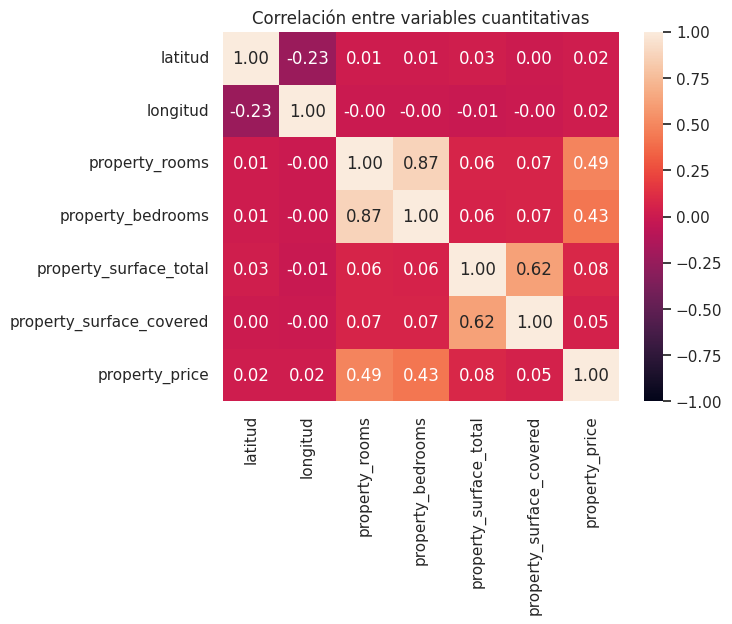

In [17]:
matriz_correlaciones = variables_cuantitativas.corr()
sns.heatmap(data=matriz_correlaciones, annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlación entre variables cuantitativas")

Observamos que las variables más relacionadas son:
 - `property_rooms` con `property_bedrooms`
 - `property_surface_covered` con `property_surface_total`
 
 y en menor medida:
 - `property_price` con `property_rooms` y `property_bedrooms`


Realizamos graficos para observar estas relaciones de forma más clara.

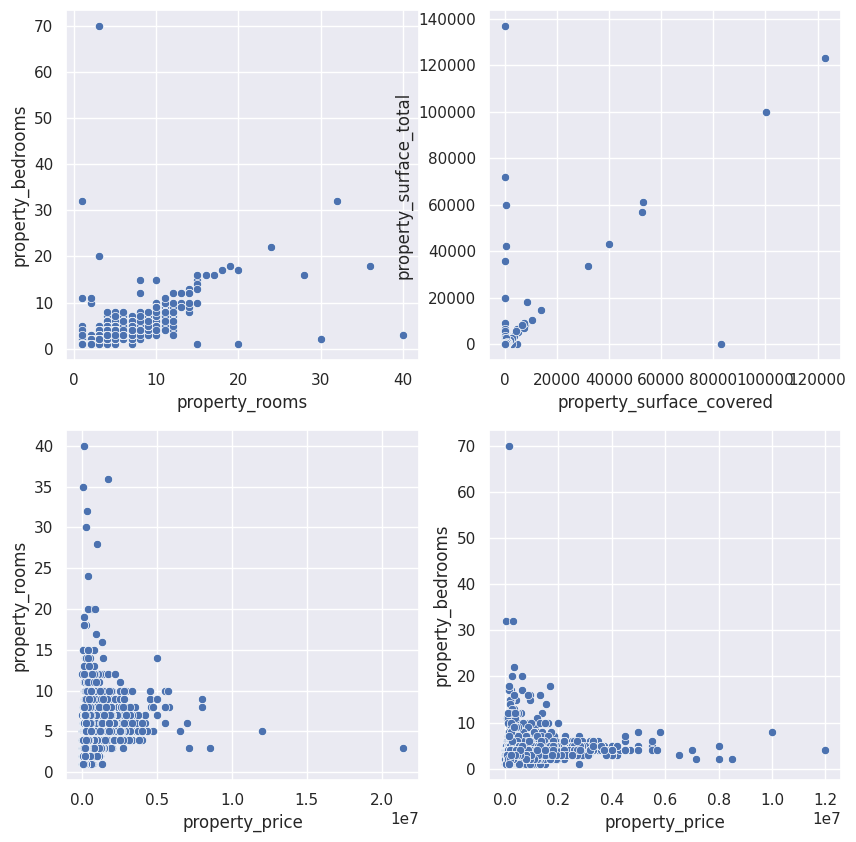

In [18]:
figs, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = np.ndarray.flatten(axes)

correlaciones = (
    ("property_rooms", "property_bedrooms"),
    ("property_surface_covered", "property_surface_total"),
    ("property_price", "property_rooms"),
    ("property_price", "property_bedrooms"),
)
for (i, correlacion) in enumerate(correlaciones):
    sns.scatterplot(ax=axes[i], data=dataset_train, x=correlacion[0], y=correlacion[1])


Observamos que hay cierta relación lineal, pero es afectada por el alto numero de valores atípicos. Si se los elimina de forma "burda" se puede ver que el gráfico cambia drásticamente, por lo que luego será necesario hacer un tratamiento de esos valores.

Graficamos con un _alpha_ para observar mejor la distribución.

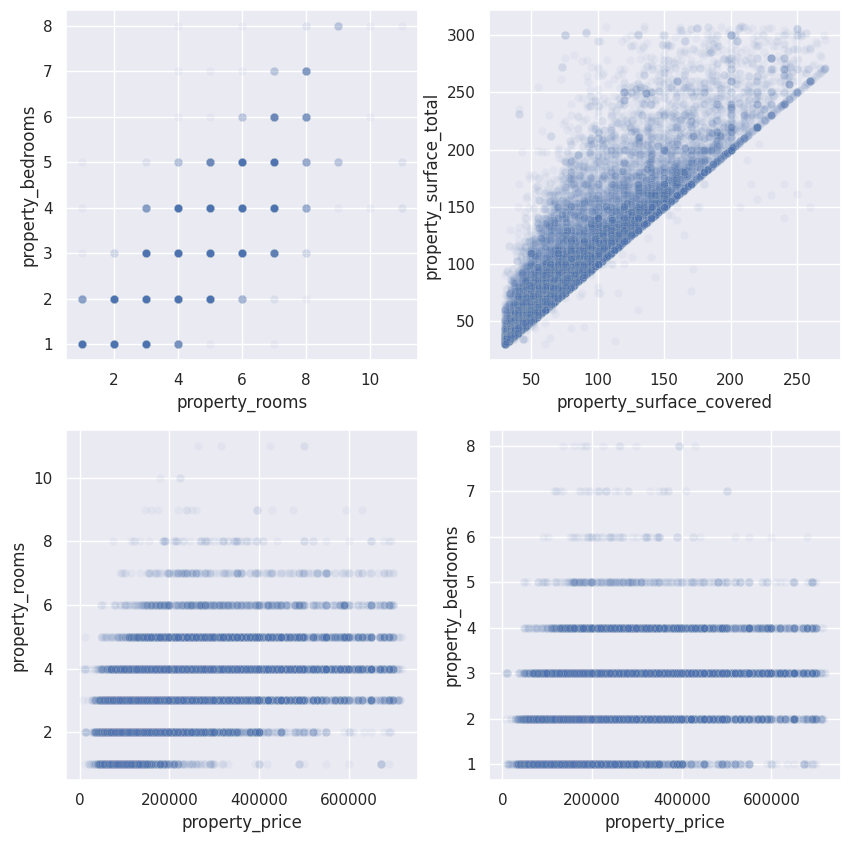

In [19]:
columnas = (
    "property_surface_covered",
    "property_surface_total",
    "property_rooms",
    "property_bedrooms",
    "property_price",
)
sin_atipicos = dataset_train.copy()
for columna in columnas:
    sin_atipicos = sin_atipicos[
        sin_atipicos[columna] < sin_atipicos[columna].quantile(0.75) * 3
    ]


figs, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = np.ndarray.flatten(axes)
for (i, correlacion) in enumerate(correlaciones):
    sns.scatterplot(ax=axes[i], data=sin_atipicos, x=correlacion[0], y=correlacion[1], alpha=0.05)


### Variables Cualitativas

Analizamos la cantidad de valores posibles de cada variable.


In [20]:
variables_cualitativas.nunique()

barrio           57
property_type     3
dtype: int64

Graficamos la distribución de los barrios y del tipo de propiedad.

[Text(0.5, 1.0, 'Distribución del tipo de propiedad'),
 Text(0.5, 0, 'tipo de propiedad'),
 Text(0, 0.5, 'frecuencia')]

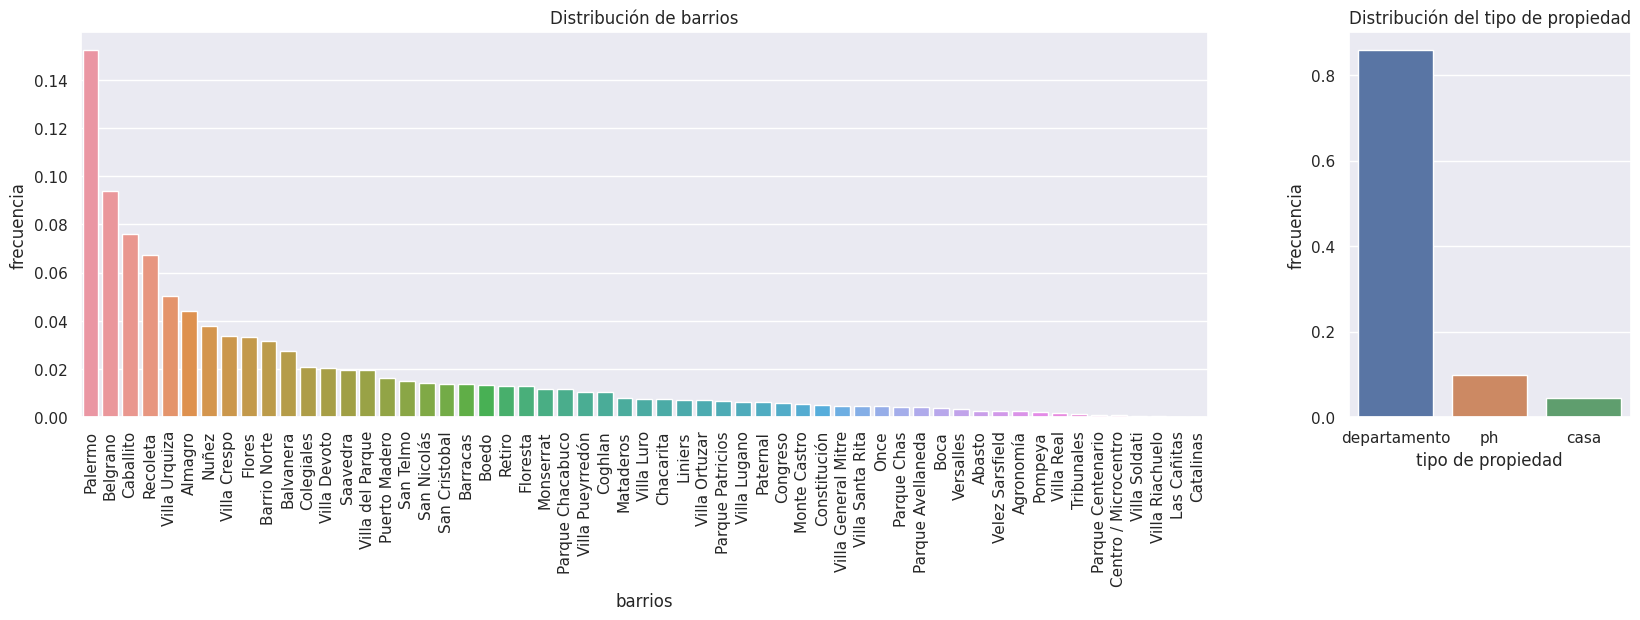

In [21]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(20, 5), gridspec_kw={"width_ratios": [4, 1]}
)

frecuencia_relativa = obtener_frecuencia_relativa(variables_cualitativas["barrio"])
ax = sns.barplot(ax=axes[0], x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(title="Distribución de barrios", xlabel="barrios", ylabel="frecuencia")
ax.tick_params("x", labelrotation=90)

frecuencia_relativa = obtener_frecuencia_relativa(
    variables_cualitativas["property_type"]
)
ax = sns.barplot(ax=axes[1], x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribución del tipo de propiedad",
    xlabel="tipo de propiedad",
    ylabel="frecuencia",
)


 ## Análisis de Valores Atípicos Univariados

Primero realizamos un **BOXPLOT** de las variables cuantitativas para observar de forma rápida la distribución de _outliers univariados_.

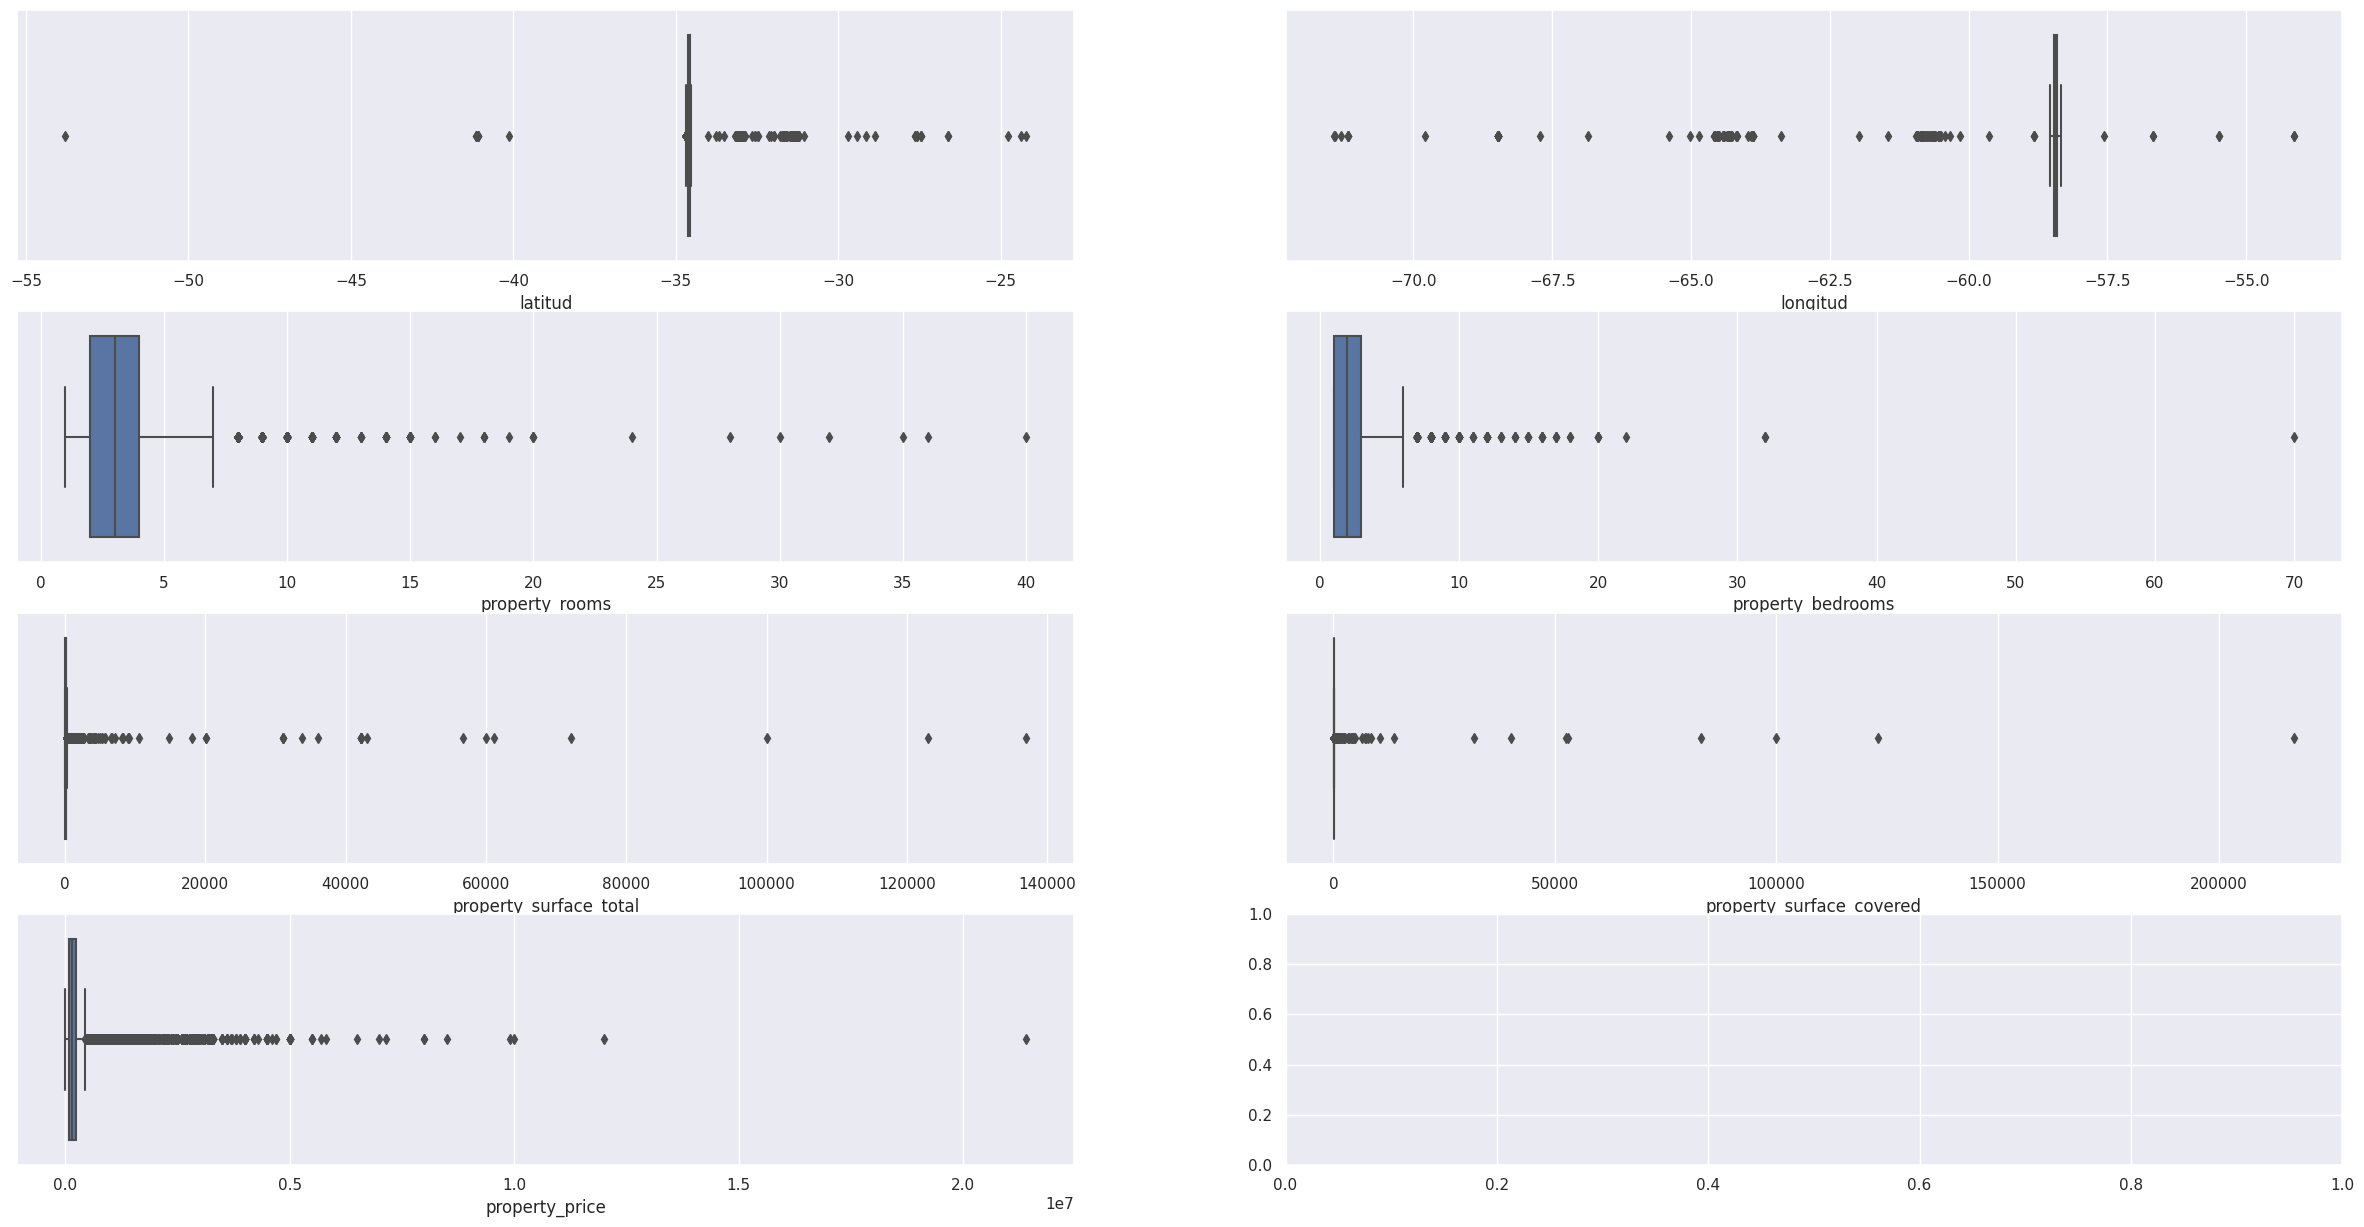

In [22]:
figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico=sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)
    

Observamos que quedan muchos valores que se salen del rango intercuartil, por lo que podemos eliminar aquellos que quedan fuera de: rango intercuartil * 3; es decir, los outliers severos.

In [23]:
for columna in variables_cuantitativas.columns:
    columna_q1 = dataset_train[columna].quantile(0.25)
    columna_q3 = dataset_train[columna].quantile(0.75)    
    iqr = columna_q3 - columna_q1

    lim_superior = columna_q3 + 3*iqr
    lim_inferior = columna_q1 - 3*iqr

    filtro_columna = (dataset_train[columna] >= lim_superior) | (dataset_train[columna] <= lim_inferior)
    indices = dataset_train[filtro_columna].index
    dataset_train.drop(index=indices, inplace=True)

    filtro_columna_test = (dataset_test[columna] >= lim_superior) | (dataset_test[columna] <= lim_inferior)
    indices_test = dataset_test[filtro_columna_test].index
    dataset_test.drop(index=indices_test, inplace=True)


Al realizar nuevamente el **BOXPLOT**, observamos que la distribuciones son mucho más uniformes

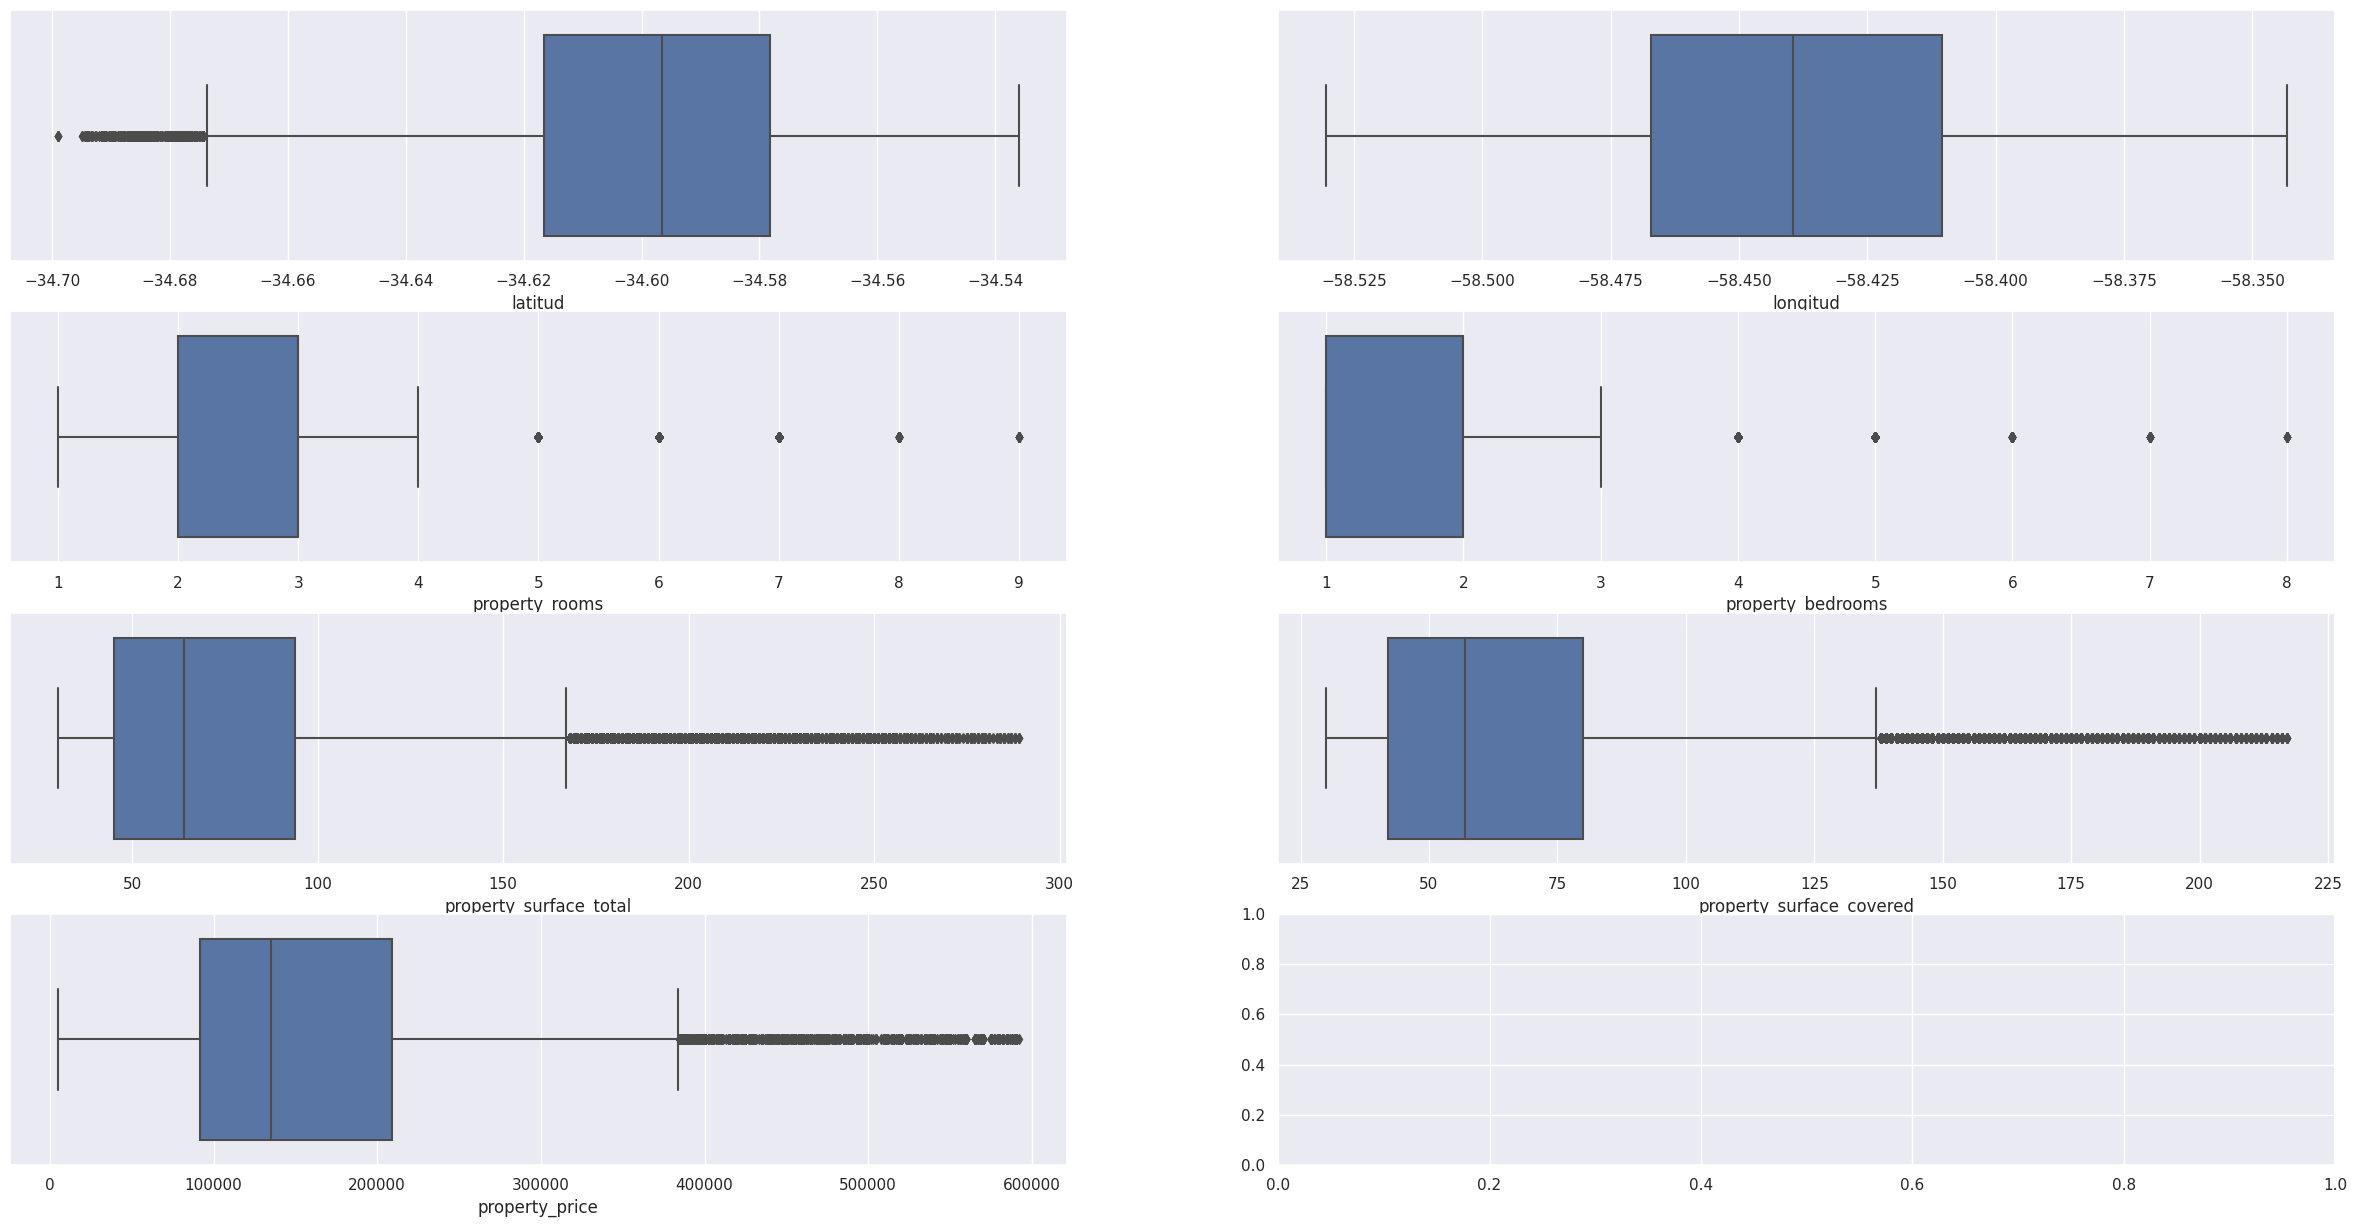

In [24]:
variables_cuantitativas = dataset_train[columnas_cuantitativas]

figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico = sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)


Observamos que si bien las distribuciones mejoraron significativamente, es necesario realizar un análisis más detallado ya que hay algunos casos extraños. Entre ellos reconocemos: el valor de `property_surface_covered` no debería ser mayor que `property_surface_total`, `property_bedrooms` no debería ser mayor a `property_rooms`, entre otros. 

In [25]:
print(dataset_train[dataset_train.property_surface_total < dataset_train.property_surface_covered].shape)
print(dataset_train[dataset_train.property_bedrooms > dataset_train.property_rooms].shape)

(90, 9)
(66, 9)


In [26]:
dataset_train.isna().sum()

latitud                     2617
longitud                    2617
barrio                       155
property_type                  0
property_rooms               554
property_bedrooms           8556
property_surface_total      5974
property_surface_covered    6493
property_price                 0
dtype: int64

In [27]:
dataset_train = dataset_train[~(dataset_train.property_surface_covered > dataset_train.property_surface_total)]
dataset_train = dataset_train[~(dataset_train.property_bedrooms > dataset_train.property_rooms)]

dataset_test = dataset_test[~(dataset_test.property_surface_covered > dataset_test.property_surface_total)]
dataset_test = dataset_test[~(dataset_test.property_bedrooms > dataset_test.property_rooms)]

## Análisis de datos faltantes


Graficamos la distribución de datos nulos.

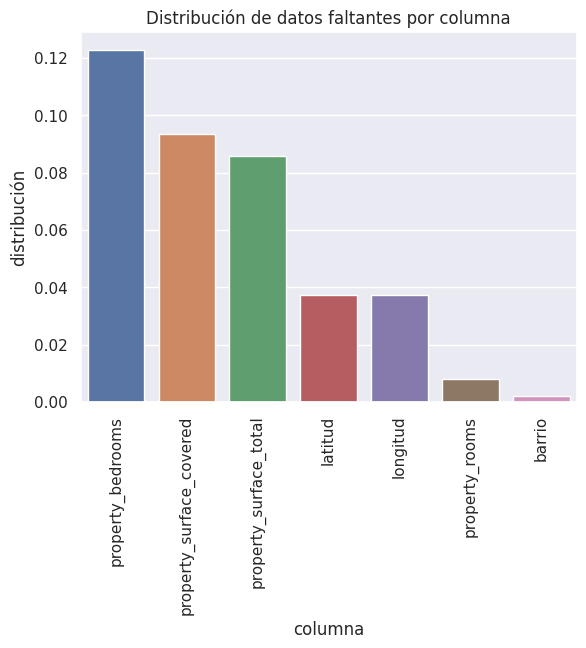

In [28]:
cantidad_de_datos_nulos_por_columna = dataset_train.isna().sum()
frecuencia_relativa = cantidad_de_datos_nulos_por_columna / dataset_train.shape[0]
frecuencia_relativa = frecuencia_relativa[frecuencia_relativa.values != 0]
frecuencia_relativa = frecuencia_relativa.sort_values(ascending=False)

ax = sns.barplot(x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribución de datos faltantes por columna",
    xlabel="columna",
    ylabel="distribución",
)
ax.tick_params("x", labelrotation=90)


Graficamos la distribución de cantidad de datos faltantes por fila. 


[Text(0.5, 0, 'Cantidad de datos faltantes por fila'),
 Text(0, 0.5, 'proporcion'),
 Text(0.5, 1.0, 'proporcion de datos faltantes por fila')]

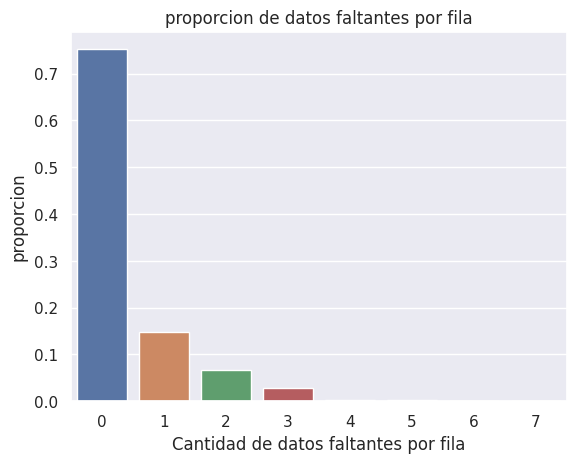

In [29]:
distribucion_faltantes_por_fila = (
    dataset_train.isna().sum(axis=1).value_counts() / dataset_train.shape[0]
)
ax = sns.barplot(
    x=distribucion_faltantes_por_fila.index,
    y=distribucion_faltantes_por_fila.values,
)
ax.set(
    xlabel="Cantidad de datos faltantes por fila",
    ylabel="proporcion",
    title="proporcion de datos faltantes por fila",
)


Vemos que quedan pocas filas con datos faltantes, por lo que podemos imputarlas.

## Imputación de datos faltantes

Algunas estrategias para imputar los datos faltantes son:

- Sustitución de Casos: Se reemplaza con valores no observados. Hay que consultar con un experto.
- Sustitución por Media: Se reemplaza utilizando la medida calculada de los valores presentes. Sin embargo, esto trae consecuencias
    - La varianza estimada por la nueva variable no es válida ya que es atenuada por los valores repetidos
    - Se distorsiona la distribución
    - Las correlaciones que se observen estaran deprimidas debido a la repetición de un solo valores constante.
- Imputación Cold Deck: Se pueden obtener los datos faltantes a partir de otras variables del dataset.
- Imputacion Hot Deck: Se reemplazan los datos faltante con los valores que resultan más “similares”. Tenemos que definir que es “similar”, para ello se puede usar la tecnica: K vecinos más cercanos.
- Imputación por Regresión: El dato faltante es reemplaza con el valor predicho por un modelo de regresión.
- MICE (multivariate imputation by chained equations): Trabaja bajo el supuesto de que el origen de los datos es MAR (missing at random). Es un proceso de imputación iterativo, donde cada iteración los valores faltantes se predicen en función de las variables restantes. El proceso se repite hasta que se encuentre consistencia en los datos (usualmente 10 iteraciones es suficiente). La primera iteración se realiza por uno de los métodos vistos anteriormente para rellenar los datos faltantes.

### Imputación de `property_bedrooms`, `property_rooms`, `property_price`

Anteriormente observamos que hay una correlación entre `property_bedrooms`, `property_rooms` y `property_price`. Podemos entrenar un modelo lineal para predecir los datos faltantes.

Imputamos los datos utilizando un imputador iterativo.

In [30]:
columnas_a_imputar = ["property_bedrooms", "property_rooms", "property_price"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    min_value=(1,1, 50000),
    max_iter=20,
    random_state=SEMILLA,
)

imp.fit(dataset_train[columnas_a_imputar])

def imputar_columnas(dataset, columnas_a_imputar):
    columnas_imputadas = imp.transform(dataset[columnas_a_imputar])
    return pd.DataFrame(columnas_imputadas, columns=columnas_a_imputar).astype(int)

dataset_imputado = imputar_columnas(dataset_train, columnas_a_imputar)
dataset_test_imputado = imputar_columnas(dataset_test, columnas_a_imputar)

Observamos que tienen la misma distribución que los datos originales.

[Text(0.5, 1.0, 'Distribución de precio de propiedad (imputado)'),
 Text(0.5, 0, 'precio de propiedad')]

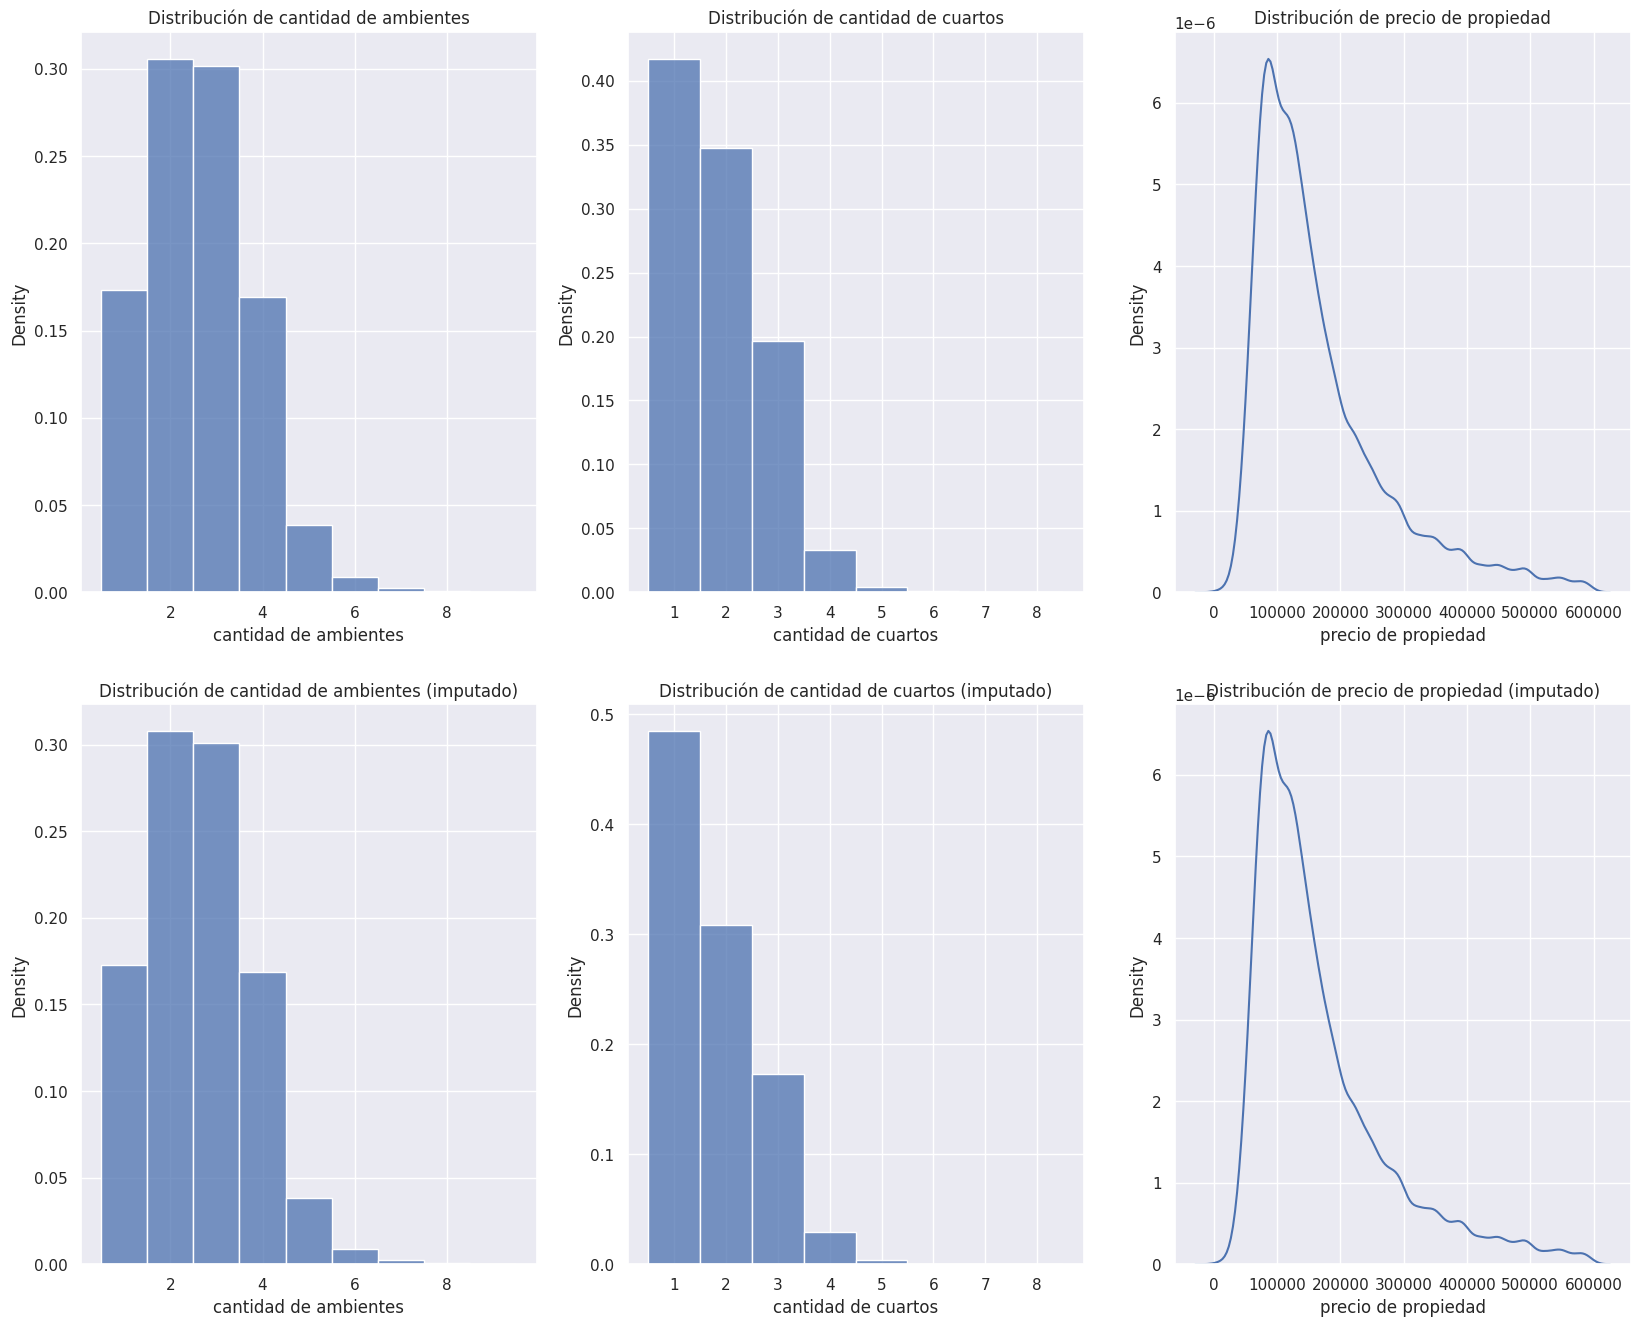

In [31]:
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 16))

ax = sns.histplot(
    ax=axes[0][0], x=dataset_train.property_rooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de ambientes", xlabel="cantidad de ambientes")

ax = sns.histplot(
    ax=axes[0][1], x=dataset_train.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de cuartos", xlabel="cantidad de cuartos")

ax = sns.kdeplot(ax=axes[0][2], x=dataset_train.property_price)
ax.set(title="Distribución de precio de propiedad", xlabel="precio de propiedad")

ax = sns.histplot(
    ax=axes[1][0], x=dataset_imputado.property_rooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de ambientes (imputado)", xlabel="cantidad de ambientes"
)

ax = sns.histplot(
    ax=axes[1][1], x=dataset_imputado.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de cuartos (imputado)", xlabel="cantidad de cuartos")

ax = sns.kdeplot(ax=axes[1][2], x=dataset_imputado.property_price)
ax.set(
    title="Distribución de precio de propiedad (imputado)", xlabel="precio de propiedad"
)


Actualizamos los valores imputados en el nuevo dataframe y vemos que las columnas imputadas ya no tienen valores faltantes.

In [32]:
dataset_test[columnas_a_imputar] = dataset_test_imputado[columnas_a_imputar].values
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values

dataset_train.isna().sum()

latitud                     2595
longitud                    2595
barrio                       149
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total      5968
property_surface_covered    6488
property_price                 0
dtype: int64

### Imputación de `property_surface_covered`, `property_surface_total`


También habíamos observado una correlación entre `property_surface_covered`, `property_surface_total` por lo que podemos entrenar otro modelo lineal para predecir estos datos faltantes.

Imputamos los datos utilizando un imputador iterativo.

In [33]:
columnas_a_imputar = ["property_surface_covered", "property_surface_total"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    max_iter=20,
    min_value=(30,30),
    verbose=0,
    random_state=SEMILLA,
)

imp.fit(dataset_train[columnas_a_imputar])

dataset_imputado = imputar_columnas(dataset_train, columnas_a_imputar)
dataset_test_imputado = imputar_columnas(dataset_test, columnas_a_imputar)

Observamos que tienen la misma distribución que los datos originales.

[Text(0.5, 1.0, 'Distribución de superficie total (imputado)'),
 Text(0.5, 0, 'superficie total')]

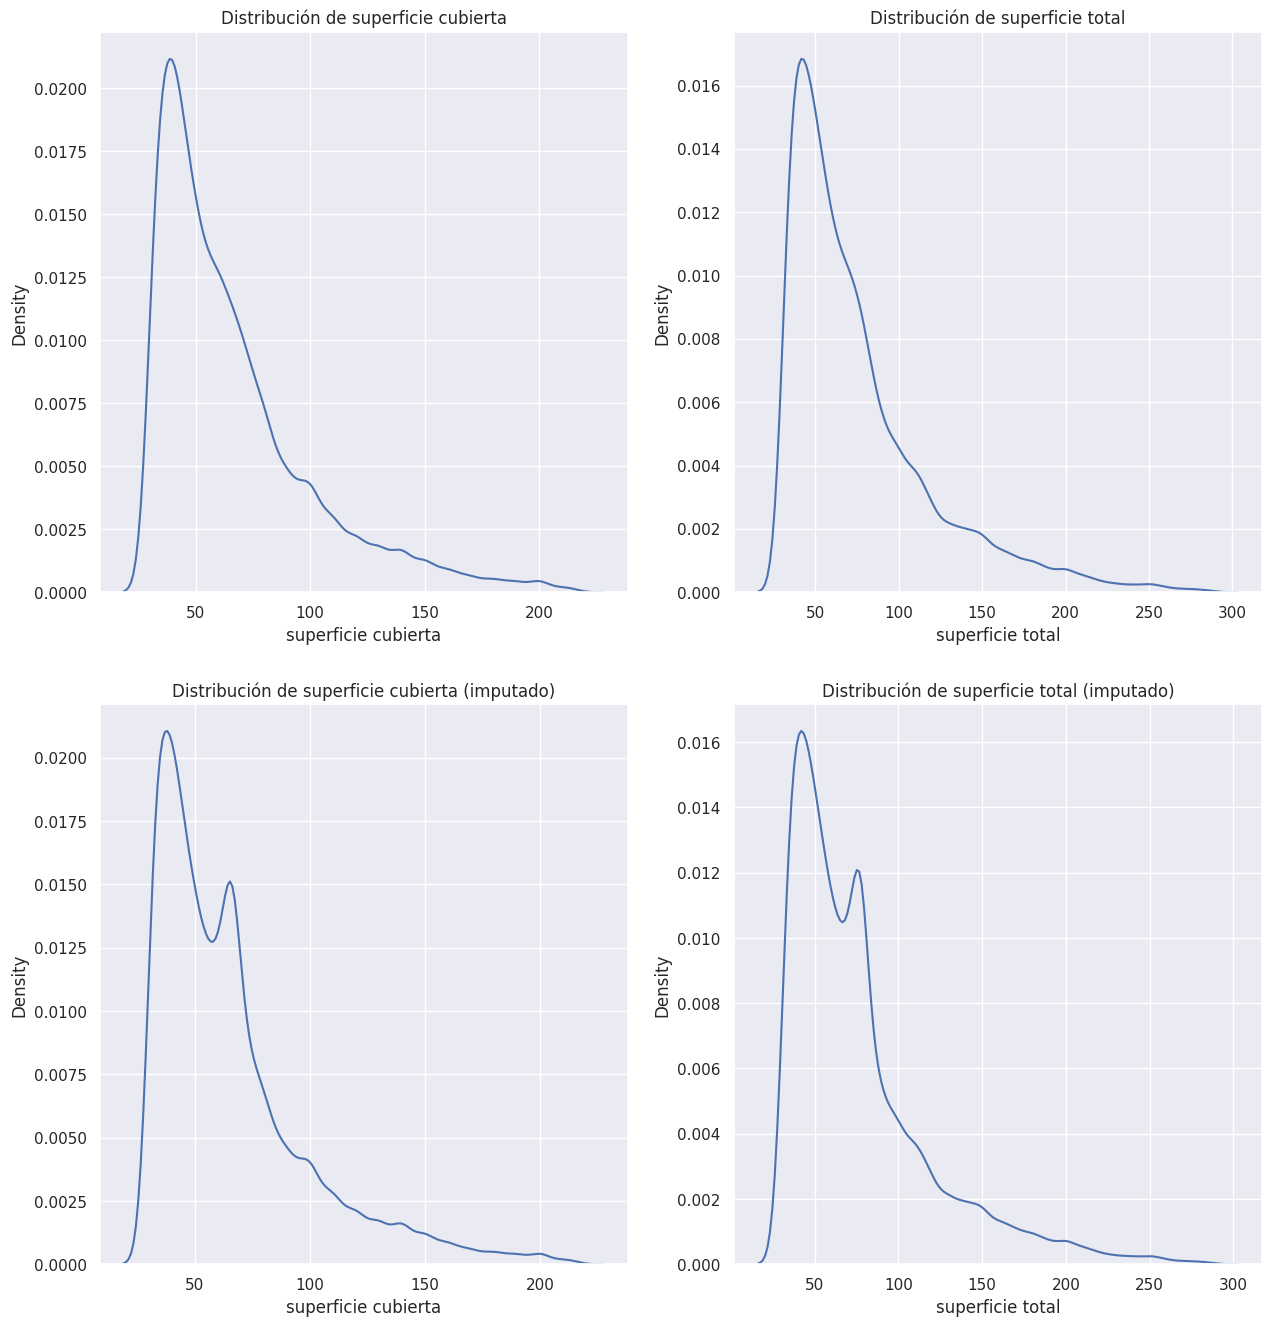

In [34]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 16))

ax = sns.kdeplot(ax=axes[0][0], x=dataset_train.property_surface_covered)
ax.set(title="Distribución de superficie cubierta", xlabel="superficie cubierta")

ax = sns.kdeplot(ax=axes[0][1], x=dataset_train.property_surface_total)
ax.set(title="Distribución de superficie total", xlabel="superficie total")

ax = sns.kdeplot(ax=axes[1][0], x=dataset_imputado.property_surface_covered)
ax.set(
    title="Distribución de superficie cubierta (imputado)", xlabel="superficie cubierta"
)

ax = sns.kdeplot(ax=axes[1][1], x=dataset_imputado.property_surface_total)
ax.set(title="Distribución de superficie total (imputado)", xlabel="superficie total")


Actualizamos los valores imputados en el nuevo dataframe y observamos que ahora las columnas imputadas ya no tienen datos nulos.

In [35]:
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values
dataset_test[columnas_a_imputar] = dataset_test_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


latitud                     2595
longitud                    2595
barrio                       149
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputacion `barrio` por `coordenadas`

Podemos entrenar un modelo que pueda predecir el barrio a partir de las coordenadas.

In [36]:
dataset_forest = dataset_train.copy()
dataset_forest.dropna(inplace=True)

factorizacion_barrio = pd.factorize(dataset_forest["barrio"])
dataset_forest["barrio"] = factorizacion_barrio[0]
definiciones_barrio = factorizacion_barrio[1]

atributos = [
    "latitud",
    "longitud"
]

target = "barrio"

X = dataset_forest[atributos]
y = dataset_forest[target]

clasificador_rfc = DecisionTreeClassifier(
    random_state=SEMILLA,
)

Separamos en train y test, y escalamos los datos para mayor performance.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = SEMILLA)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Ahora, entrenamos el modelo y vemos su desempeño

In [38]:
clasificador_rfc.fit(X_train, y_train)

clasificador_rfc.score(X_test, y_test)

0.8206680116565792

El desempeño es excelente, lo podemos utilizar para imputar los barrios faltantes. Sin embargo, solo lo podemos aplicar en filas que contengan coordenadas.

In [39]:
def imputar_barrio(fila):
    if fila["barrio"] != None:
        return fila

    if fila[atributos].isna().any():
        return fila

    barrio = clasificador_rfc.predict([fila[atributos].copy()])

    fila["barrio"] = definiciones_barrio[barrio[0]]

    return fila

dataset_train = dataset_train.apply(imputar_barrio, axis=1)
dataset_test = dataset_test.apply(imputar_barrio, axis=1)

Observamos la distribucón de faltantes hasta ahora.

In [40]:
dataset_train.isna().sum()

latitud                     2595
longitud                    2595
barrio                       106
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputación de `latitud`, `longitud` según `barrio`

Primero, buscamos el punto medio de cada barrio, para luego reemplazarlo en las coordenadas faltantes.

In [41]:
columnas_ubicacion = ["latitud", "longitud", "barrio"]
dataset_ubicaciones = dataset_train[columnas_ubicacion]
promedio_ubicaciones = dataset_ubicaciones.groupby("barrio").mean()


Ahora, podemos reemplazar los datos de latitud y longitud faltantes con el promedio para el barrio al que pertenecen.

In [42]:
def imputar_cordenada(fila):
    barrio = fila["barrio"]

    if barrio == None:
        return fila

    if np.isnan(fila["latitud"]):
        fila["latitud"] = promedio_ubicaciones.at[barrio, "latitud"]

    if np.isnan(fila["longitud"]):
        fila["longitud"] = promedio_ubicaciones.at[barrio, "longitud"]

    return fila
    
dataset_train = dataset_train.apply(imputar_cordenada, axis=1)
dataset_test = dataset_test.apply(imputar_cordenada, axis=1)

Observamos la distribución de datos faltantes.

In [43]:
dataset_train.isna().sum()

latitud                     106
longitud                    106
barrio                      106
property_type                 0
property_rooms                0
property_bedrooms             0
property_surface_total        0
property_surface_covered      0
property_price                0
dtype: int64

### Datos Faltantes Restanes

Finalmente, tenemos una cantidad muy baja de valores faltantes en la ubicación. Los podemos quitar para facilitar los análisis posteriores.

In [44]:
dataset_train = dataset_train[~dataset_train.barrio.isna()]
dataset_test = dataset_test[~dataset_test.barrio.isna()]

In [45]:
dataset_train.isna().sum()

latitud                     0
longitud                    0
barrio                      0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
dtype: int64

## Análisis de Valores Atípicos Multivariados

Al intentar aplicar la medida de distancia Mahalanobis el algoritmo no funcionaba ya que multiplicar matrices de dimensiones tan altas requería de una cantidad de memoria RAM demasiado grande . Por otro lado, el algoritmo LOF tampoco funcionaba del todo bien ya que la información no está ordenada en clusters, por lo que los cálculos de densidad no daban bien. Debido a esto decidimos aplicar `IsolationForest` para analizar la presencia de valores atípicos multivariados.  

### Isolation Forest General

Para analizar los valores atípicos multivariados, vamos a utilizar el algoritmo `IsolationForest` con todas las variables numéricas.

In [46]:
columnas = [
    "property_surface_total",
    "property_surface_covered",
    "property_rooms",
    "property_bedrooms",
    "property_price",
]

dataset_isolation_forest = dataset_train[columnas].copy()
dataset_isolation_forest_test = dataset_test[columnas].copy()

iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=len(columnas),
    bootstrap=False,
    n_jobs=-1,
    random_state=SEMILLA,
)

dataset_isolation_forest["outlier"] = iforest.fit_predict(dataset_isolation_forest)
dataset_isolation_forest["outlier"] = dataset_isolation_forest["outlier"].replace(to_replace=[-1, 1], value=[True, False])

dataset_isolation_forest_test["outlier"] = iforest.predict(dataset_isolation_forest_test)
dataset_isolation_forest_test["outlier"] = dataset_isolation_forest_test["outlier"].replace(to_replace=[-1, 1], value=[True, False])

print("Cantidad de observaciones anómalas:")
print(dataset_isolation_forest["outlier"].value_counts())

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
Cantidad de observaciones anómalas:
False    65973
True      3473
Name: outlier, dtype: int64


Realizamos un **pair plot** para analizar las correlaciones y cantidad de valores atípicos entre las variables.

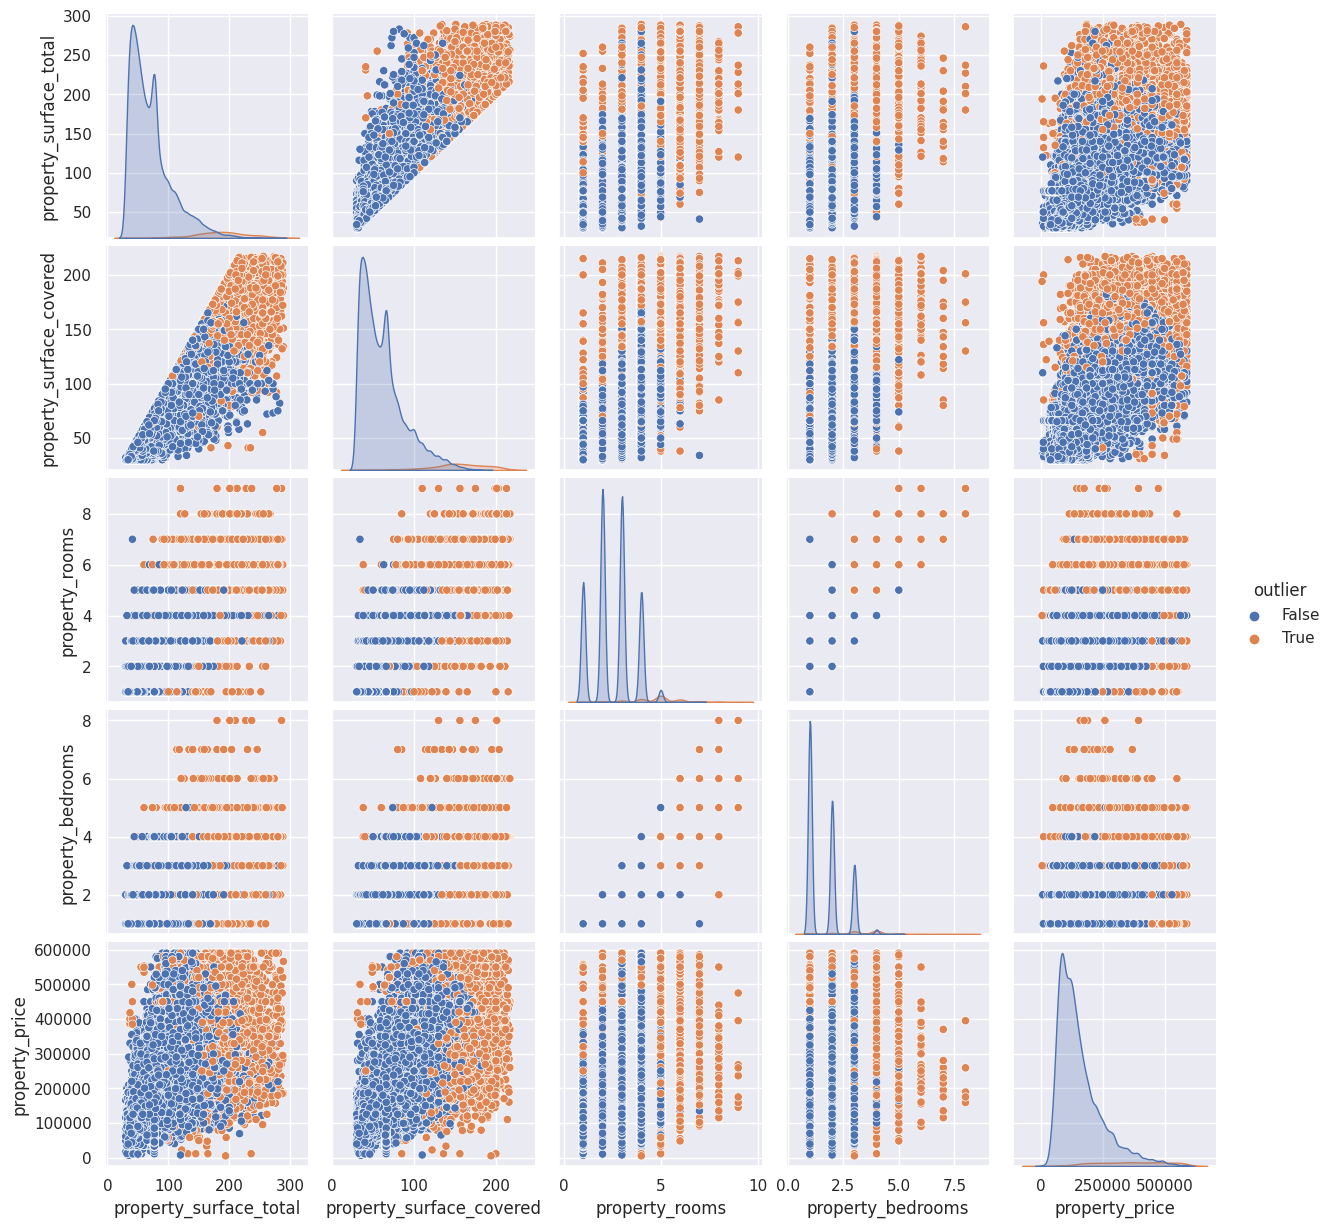

In [47]:
sns.pairplot(data=dataset_isolation_forest, hue="outlier")

Luego graficamos el árbol que se creó para la detección de outliers.

In [48]:

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

estimator = iforest.estimators_[5]

export_graphviz(estimator,out_file='tree.dot',max_depth=5,
                feature_names = columnas,
                special_characters=True,rounded=True,precision=2)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')


Por último, quitamos las filas que son detectadas como outliers.

In [49]:

dataset_train = dataset_train[~dataset_isolation_forest.outlier]
dataset_test = dataset_test[~dataset_isolation_forest_test.outlier]

### Isolation Forest para `property_surface_total` y `property_price`

Ahora vamos a analizar la distribución de valores atipicos en únicamente las columnas `property_surface_total` y `property_price`.

Graficamos la distribución de estas variables en un **scatter plot**.

<AxesSubplot:xlabel='property_surface_total', ylabel='property_price'>

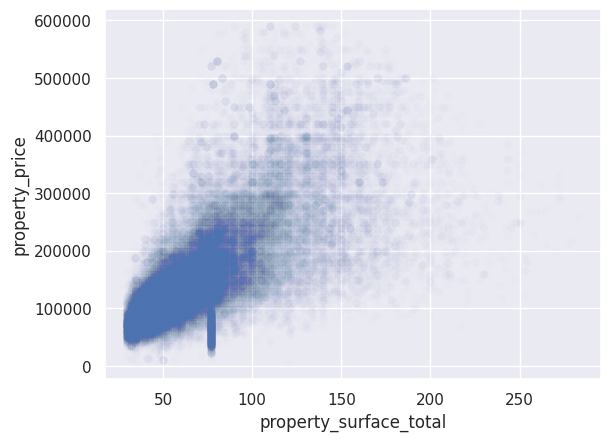

In [50]:
sns.scatterplot(data=dataset_train, x="property_surface_total", y="property_price", alpha=0.01)

Observamos que hay mucha concentración, con algunas observaciones dispersas. Realizamos otro `isolation forest` para identificarlas.

In [51]:
columnas = [
    "property_surface_total",
    "property_price",
]

dataset_isolation_forest = dataset_train[columnas].copy()
dataset_isolation_forest_test = dataset_test[columnas].copy()

iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=len(columnas),
    bootstrap=False,
    n_jobs=-1,
    random_state=SEMILLA,
)

dataset_isolation_forest["outlier"] = iforest.fit_predict(dataset_isolation_forest)
dataset_isolation_forest["outlier"] = dataset_isolation_forest["outlier"].replace(to_replace=[-1, 1], value=[True, False])

dataset_isolation_forest_test["outlier"] = iforest.predict(dataset_isolation_forest_test)
dataset_isolation_forest_test["outlier"] = dataset_isolation_forest_test["outlier"].replace(to_replace=[-1, 1], value=[True, False])

print("Cantidad de observaciones anómalas:")
print(dataset_isolation_forest["outlier"].value_counts())

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
Cantidad de observaciones anómalas:
False    62675
True      3298
Name: outlier, dtype: int64


Graficamos la distribución de outliers encontrada.

<AxesSubplot:xlabel='property_surface_total', ylabel='property_price'>

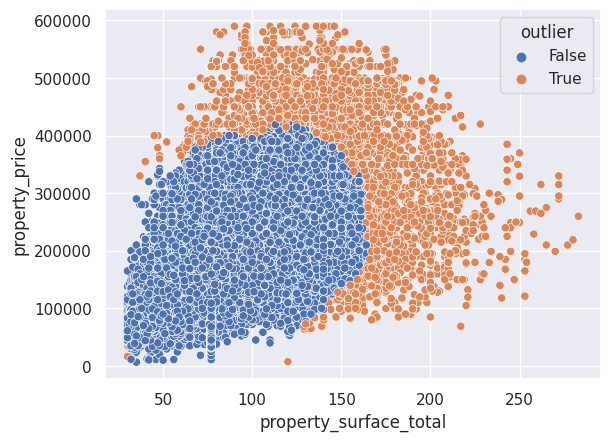

In [52]:
sns.scatterplot(data=dataset_isolation_forest, x="property_surface_total", y="property_price", hue="outlier")

Nuevamente, quitamos las filas clasificadas como outliers.

In [53]:
dataset_train = dataset_train[~dataset_isolation_forest.outlier]
dataset_test = dataset_test[~dataset_isolation_forest_test.outlier]

Observamos la forma de nuestro `dataset_train`, luego del preprocesamiento. Luego de las imputaciones y eliminación de los outliers y datos faltantes que no se pudieron imputar tenemos el dataset que se utilizará para entrenar modelos y realizar predicciones.

In [54]:
dataset_train.shape

(62675, 9)

## Reducción de Dimensionalidad

Para la reducción de la dimensionalidad usaremos el método de PCA ya que esta técnica permite hallar las combinaciones lineales de las variables originales que maximizan la varianza, es decir, minimizan la pérdida de información original.

Primero, transformamos el dataset en un dataset con variables numéricas, normalizamos los atributos y escalamos las variables.

In [55]:
columnas = [
    "property_surface_total",
    "property_surface_covered",
    "property_rooms",
    "property_bedrooms",
    "property_price",
]

dataset_pca = dataset_train[columnas].copy()
dataset_pca_test = dataset_test[columnas].copy()

x = dataset_pca.values
scaler = StandardScaler().fit(x)
x = scaler.transform(x)

x_test = dataset_pca_test.values
x_test = scaler.transform(x_test)

Luego, le aplicamos el algoritmo de PCA.

In [56]:
from sklearn.decomposition import PCA

cantidad_componentes = len(dataset_pca.columns)

pca = PCA(n_components=cantidad_componentes) 
x_transformada = pca.fit_transform(x)
x_transformada_test = pca.transform(x_test)

componentes_caracteristicos = [f"cp_{n}" for n in range(cantidad_componentes)]

dataset_pca_transformado = pd.DataFrame(data = x_transformada, columns = componentes_caracteristicos)
dataset_pca_transformado_test = pd.DataFrame(data = x_transformada_test, columns = componentes_caracteristicos)

print(cantidad_componentes)

5


Graficamos la varianza explicada en relación a la cantidad de componentes principales en un **scree plot**.

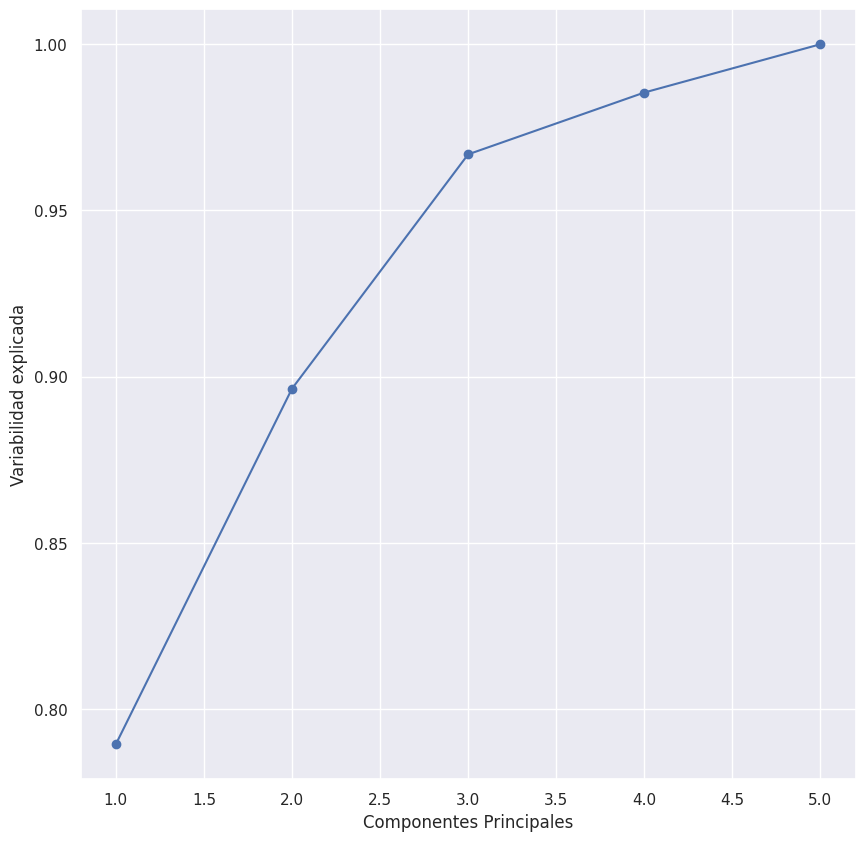

In [57]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Gráfico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(10, 10))
plt.plot(list_x, varianza_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

In [58]:
n_componentes_elegido = 3
print(f"La varianza explicada tomando {n_componentes_elegido} componentes principales es {varianza_explicada[:n_componentes_elegido].sum()}")

La varianza explicada tomando 3 componentes principales es 0.9668796545424387


Por lo tanto, concluimos que nos podemos quedar con 3 componentes principales, sin perder mucha variabilidad en los datos.

In [59]:
dataset_pca_transformado = dataset_pca_transformado.iloc[: , :n_componentes_elegido]
dataset_pca_transformado_test= dataset_pca_transformado_test.iloc[: , :n_componentes_elegido]
dataset_concatenado = pd.concat([
    dataset_pca_transformado.reset_index(drop=True), 
    dataset_train[columnas_cualitativas].reset_index(drop=True)], 
    axis=1,
    join='inner')

dataset_concatenado_test = pd.concat([
    dataset_pca_transformado_test.reset_index(drop=True), 
    dataset_train[columnas_cualitativas].reset_index(drop=True)], 
    axis=1,
    join='inner')
    
dataset_concatenado.head()

cp_0      cp_1      cp_2        barrio property_type
0 -0.524277 -0.851428 -0.207161      Belgrano  departamento
1  0.700145  0.523525  0.251180     Monserrat  departamento
2  0.185696 -1.630971 -0.466654       Palermo  departamento
3  2.554781  1.098680  0.131715  Barrio Norte  departamento
4 -2.278473 -0.319207 -0.214755       Palermo  departamento

# 2. Agrupamiento

Primero vamos a realizar un analisis de Hopkins para determinar la tendencia al _clustering_ del dataset, midiendo la probabilidad de que el conjunto de datos dado sea generado por una distribución de datos uniforme. Es decir, prueba la aleatoriedad espacial de los datos y ve como estos se distribuyen en dicho espacio.


In [60]:
from pyclustertend import hopkins

dataset_agrupamiento = pd.get_dummies(dataset_train, drop_first=True)

hopkins(dataset_agrupamiento,dataset_agrupamiento.shape[0])

0.022789909144300367

Vemos que la tendencia es al agrupamiento es muy alta, por lo que utilizamos el **elbow method** para buscar qué número de grupos brinda el mejor agrupamiento.

### Elbow Method

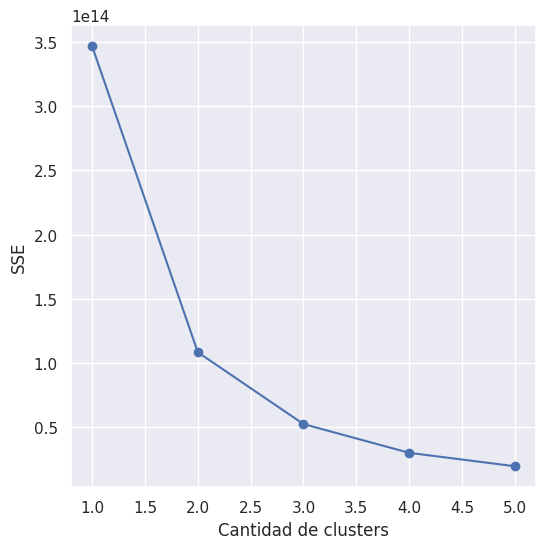

In [61]:
sse = []
list_k = list(range(1, 6))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(dataset_agrupamiento)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

Siguiendo la regla del codo, elegimos $k=2$ ya que el codo se quiebra en ese punto. Ahora vamos a aplicar la tecnica de Silhoute para evaluar la calidad de los clusters.

### Silhouette

In [62]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(dataset_agrupamiento)

    score = silhouette_score (dataset_agrupamiento, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.6427118541252866
For n_clusters =3 silhouette score is 0.5765256806638588
For n_clusters =4 silhouette score is 0.5641346102934652
For n_clusters =5 silhouette score is 0.5601626251644244


Podemos observar que el mejor score se obtiene con $2$ clusters, dado que es el valor más cercano a $1$, y graficamos su **silhouette** para poder verlo gráficamente. 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


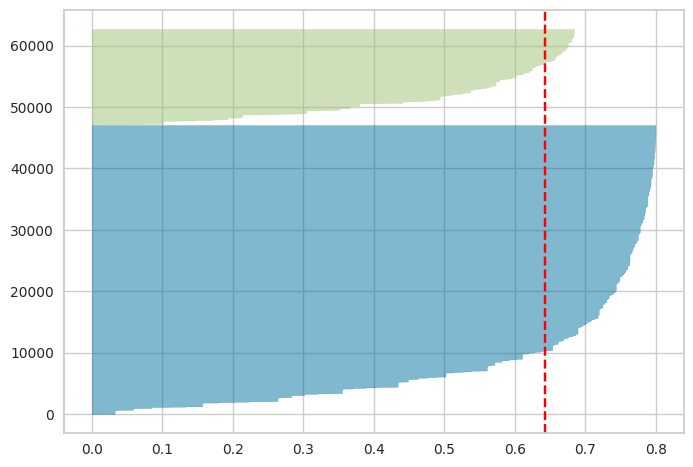

In [63]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(2, random_state = SEMILLA)

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(dataset_agrupamiento)
plt.show()

Al analizar que los datos se agrupan en $2$ grupos podemos suponer que el agrupamiento se realiza a partir de la variable `property_type`, que puede tomar 3 valores: Casa, Departamento y PH. Este último comparte características con los primeros dos, por lo que tiene sentido que el algoritmo clasifique algunos PH como Casa y otros como Departamento.

### Gráfico de Clusters con $k=2$

Agregamos una columna al dataset con la información sobre a qué cluster pertenece.

In [64]:
model = KMeans(2, random_state=SEMILLA)
model.fit(dataset_agrupamiento)

dataset_agrupamiento['cluster'] = model.predict(dataset_agrupamiento)
color_map = {0: 'red', 1: 'blue'}
dataset_agrupamiento.head()

latitud   longitud  property_rooms  property_bedrooms  \
83944  -34.554271 -58.457668               2                  1   
195386 -34.613544 -58.368072               3                  2   
293157 -34.571020 -58.433125               2                  1   
384577 -34.597384 -58.405139               4                  3   
450142 -34.591646 -58.418064               1                  1   

        property_surface_total  property_surface_covered  property_price  \
83944                       59                        59          178000   
195386                      71                        71          129000   
293157                      79                        59          249000   
384577                      91                        85          165000   
450142                      37                        32          105000   

        barrio_Agronomía  barrio_Almagro  barrio_Balvanera  ...  \
83944                  0               0                 0  ...   
195386                 0               0                 0  ...   
293157                 0               0                 0  ...   
384577                 0               0                 0  ...   
450142                 0               0                 0  ...   

        barrio_Villa Pueyrredón  barrio_Villa Real  barrio_Villa Riachuelo  \
83944                         0                  0                       0   
195386                        0                  0                       0   
293157                        0                  0                       0   
384577                        0                  0                       0   
450142                        0                  0                       0   

        barrio_Villa Santa Rita  barrio_Villa Soldati  barrio_Villa Urquiza  \
83944                         0                     0                     0   
195386                        0                     0                     0   
293157                        0                     0                     0   
384577                        0                     0                     0   
450142                        0                     0                     0   

        barrio_Villa del Parque  property_type_departamento  property_type_ph  \
83944                         0                           1                 0   
195386                        0                           1                 0   
293157                        0                           1                 0   
384577                        0                           1                 0   
450142                        0                           1                 0   

        cluster  
83944         0  
195386        0  
293157        1  
384577        0  
450142        0  

[5 rows x 66 columns]

Graficamos sobre un mapa de CABA las propiedades coloreadas según al grupo al que pertenecen.

In [65]:
dataset_agrupamiento.shape

(62675, 66)

/shared-libs/python3.9/py/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
(62675, 65)


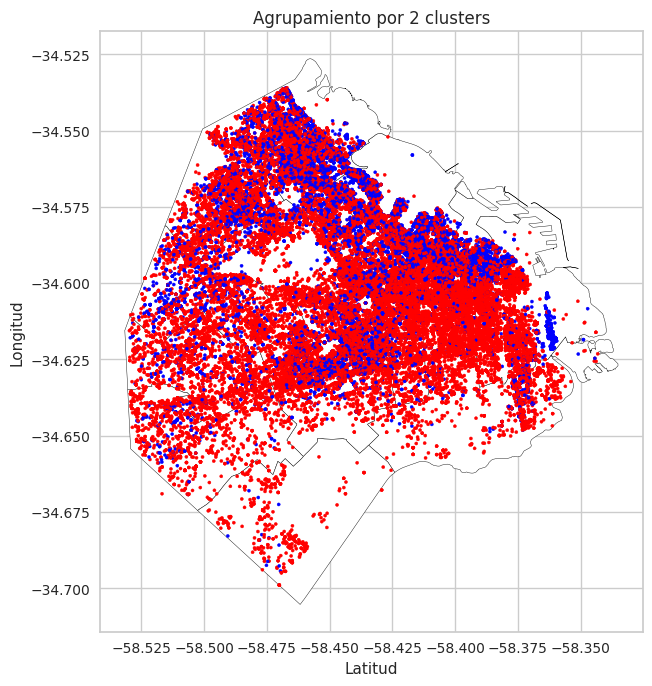

In [66]:
def graficar_mapa_caba(dataset, color_map, title):

    fig, ax = plt.subplots(figsize=(7, 10))

    df = dataset_agrupamiento[(dataset_agrupamiento['latitud'] < -34) & (dataset_agrupamiento['latitud'] > -35) & (dataset_agrupamiento['longitud'] > -59)]
    gdf = gpd.GeoDataFrame(df.drop(['latitud', 'longitud'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=[shapely.geometry.Point(xy)
                                 for xy in zip(df.longitud, df.latitud)])
    world = gpd.read_file('comunas/comunas_wgs84.shp')

    base = world.plot(ax=ax, color='white', edgecolor='black')

    gdf.plot(ax=base, marker='o', markersize=5, c=[color_map[label] for label in model.labels_])
    ax.set(title=title, xlabel="Latitud", ylabel="Longitud")
    print(gdf.shape)
    plt.show()

graficar_mapa_caba(dataset_agrupamiento, color_map, "Agrupamiento por 2 clusters")

### Clusters con $k=3$

Repetimos el análisis con $k=3$, dado que es el segundo valor con mayor silhouette score después de $k=2$.

In [67]:
model = KMeans(3, random_state=SEMILLA)
model.fit(dataset_agrupamiento)

dataset_agrupamiento['cluster'] = model.predict(dataset_agrupamiento)
dataset_agrupamiento.head()

latitud   longitud  property_rooms  property_bedrooms  \
83944  -34.554271 -58.457668               2                  1   
195386 -34.613544 -58.368072               3                  2   
293157 -34.571020 -58.433125               2                  1   
384577 -34.597384 -58.405139               4                  3   
450142 -34.591646 -58.418064               1                  1   

        property_surface_total  property_surface_covered  property_price  \
83944                       59                        59          178000   
195386                      71                        71          129000   
293157                      79                        59          249000   
384577                      91                        85          165000   
450142                      37                        32          105000   

        barrio_Agronomía  barrio_Almagro  barrio_Balvanera  ...  \
83944                  0               0                 0  ...   
195386                 0               0                 0  ...   
293157                 0               0                 0  ...   
384577                 0               0                 0  ...   
450142                 0               0                 0  ...   

        barrio_Villa Pueyrredón  barrio_Villa Real  barrio_Villa Riachuelo  \
83944                         0                  0                       0   
195386                        0                  0                       0   
293157                        0                  0                       0   
384577                        0                  0                       0   
450142                        0                  0                       0   

        barrio_Villa Santa Rita  barrio_Villa Soldati  barrio_Villa Urquiza  \
83944                         0                     0                     0   
195386                        0                     0                     0   
293157                        0                     0                     0   
384577                        0                     0                     0   
450142                        0                     0                     0   

        barrio_Villa del Parque  property_type_departamento  property_type_ph  \
83944                         0                           1                 0   
195386                        0                           1                 0   
293157                        0                           1                 0   
384577                        0                           1                 0   
450142                        0                           1                 0   

        cluster  
83944         0  
195386        1  
293157        2  
384577        0  
450142        1  

[5 rows x 66 columns]

Realizamos el gráfico silhouette para ver el agrupamiento.

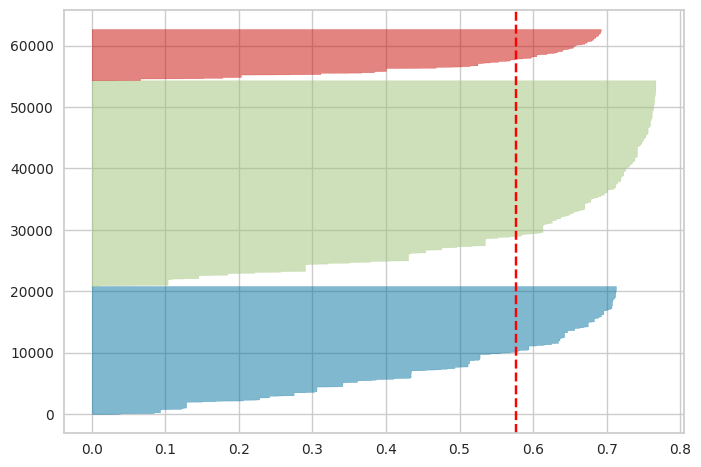

In [68]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(3, random_state = SEMILLA)

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(dataset_agrupamiento)
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
(62675, 65)


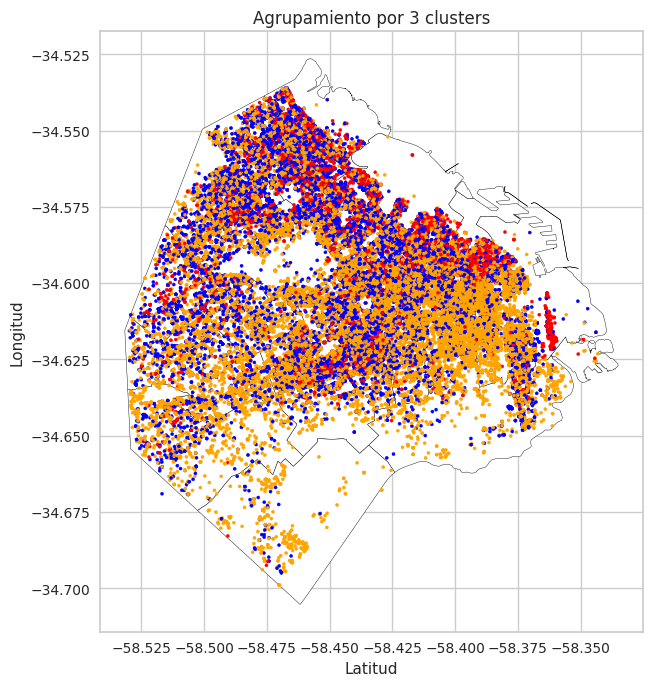

In [69]:
color_map = {0: "blue", 1: "orange", 2: "red"}
graficar_mapa_caba(dataset_agrupamiento, color_map, "Agrupamiento por 3 clusters")

# 3. Clasificación

## Construcción del Target

Creamos la variable `pxm2` (precio por metro cuadrado) para luego utilizarla en el análisis de clasificación. 

In [70]:
dataset_clasificacion = dataset_train.copy()    
dataset_clasificacion["pxm2"] = dataset_clasificacion.property_price / dataset_clasificacion.property_surface_total

dataset_clasificacion_test = dataset_test.copy()    
dataset_clasificacion_test["pxm2"] = dataset_clasificacion_test.property_price / dataset_clasificacion_test.property_surface_total



Graficamos la distribución del precio por metro cuadrado.

[Text(0.5, 1.0, 'Distribución de precio por metro cuadrado'),
 Text(0.5, 0, 'precio'),
 Text(0, 0.5, 'distribución')]

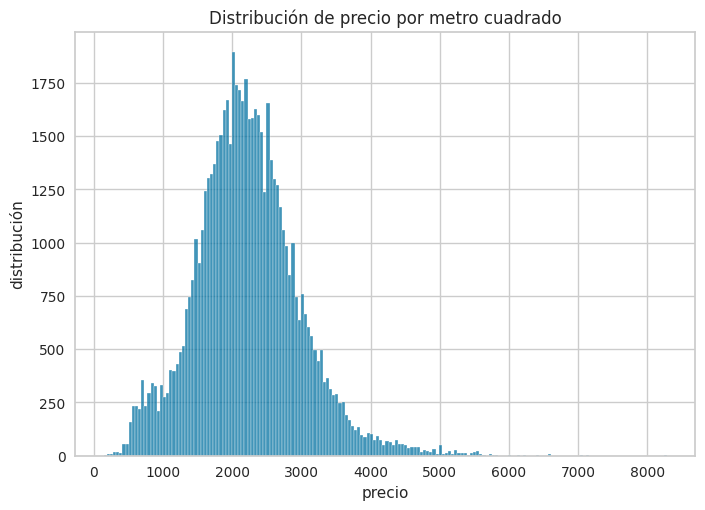

In [71]:
ax = sns.histplot(x=dataset_clasificacion["pxm2"])
ax.set(title="Distribución de precio por metro cuadrado", xlabel="precio", ylabel="distribución")


Ahora graficamos la distribución del precio por metro cuadrado por tipo de propiedad.

[Text(0.5, 1.0, 'Distribución de precio por metro cuadrado'),
 Text(0.5, 0, 'precio'),
 Text(0, 0.5, 'distribución')]

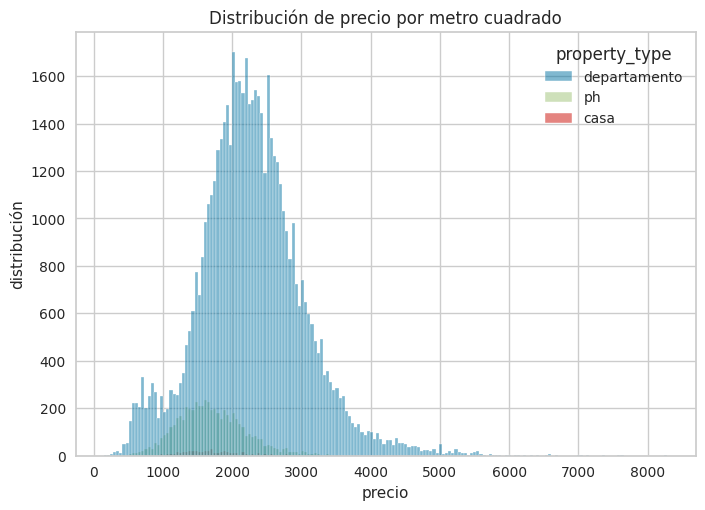

In [72]:
ax = sns.histplot(data=dataset_clasificacion, x=dataset_clasificacion["pxm2"], hue="property_type")
ax.set(title="Distribución de precio por metro cuadrado", xlabel="precio", ylabel="distribución")

Creamos tres columnas de `tipo_precio` utilizando las 3 alternativas propuestas y luego analizamos la distribución de la nueva variable creada.

#### Alternativa 1

In [73]:
labels = ["bajo", "medio", "alto"]

dataset_clasificacion["tipo_precio_1"] = pd.qcut(dataset_clasificacion["pxm2"], q=[0, 1/3, 2/3, 1], labels=labels)
#dataset_clasificacion_test["tipo_precio_1"] = pd.qcut(dataset_clasificacion_test["pxm2"], q=[0, 1/3, 2/3, 1], labels=labels)


[Text(0.5, 1.0, 'Distribución del tipo de precio'),
 Text(0.5, 0, 'tipo de precio'),
 Text(0, 0.5, 'frecuencia')]

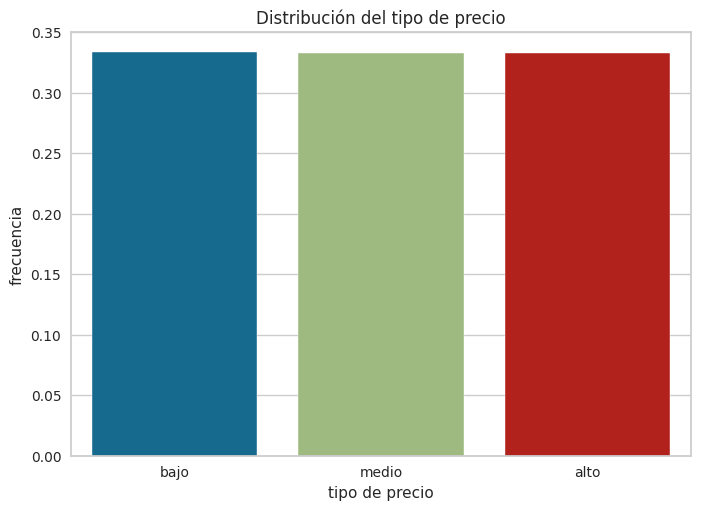

In [74]:
frecuencia_relativa = obtener_frecuencia_relativa(
    dataset_clasificacion["tipo_precio_1"]
)
ax = sns.barplot(x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribución del tipo de precio",
    xlabel="tipo de precio",
    ylabel="frecuencia",
)


#### Alternativa 2

In [75]:
dataset_clasificacion["tipo_precio_2"] = pd.qcut(dataset_clasificacion["pxm2"], q=[0, 0.25, 0.75, 1], labels=labels)

[Text(0.5, 1.0, 'Distribución del tipo de precio'),
 Text(0.5, 0, 'tipo de precio'),
 Text(0, 0.5, 'frecuencia')]

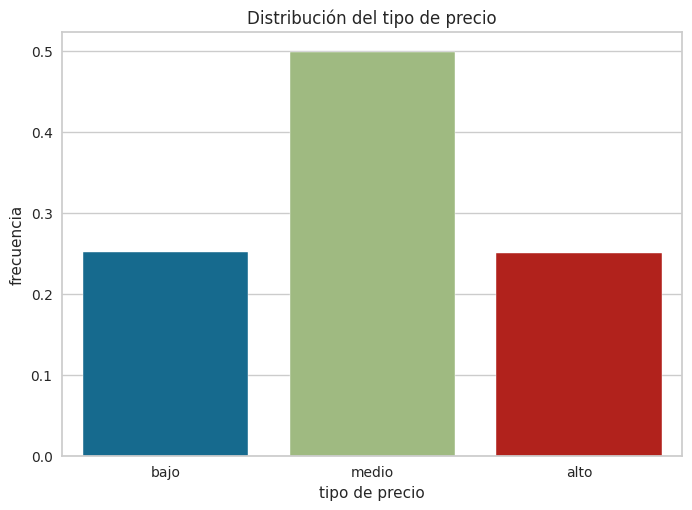

In [76]:
frecuencia_relativa = obtener_frecuencia_relativa(
    dataset_clasificacion["tipo_precio_2"]
)
ax = sns.barplot(x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribución del tipo de precio",
    xlabel="tipo de precio",
    ylabel="frecuencia",
)


#### Alternativa 3

In [77]:
def establecer_limites_categorias(dataset_clasificacion):

    dataset_ph = dataset_clasificacion[dataset_clasificacion.property_type == "ph"].copy()
    dataset_ph["tipo_precio_3"] = pd.qcut(dataset_ph["pxm2"], q=[0, 0.25, 0.75, 1], labels=labels)

    dataset_dep = dataset_clasificacion[dataset_clasificacion.property_type == "departamento"].copy()
    dataset_dep["tipo_precio_3"] = pd.qcut(dataset_dep["pxm2"], q=[0, 0.25, 0.75, 1], labels=labels)

    dataset_casa = dataset_clasificacion[dataset_clasificacion.property_type == "casa"].copy()
    dataset_casa["tipo_precio_3"] = pd.qcut(dataset_casa["pxm2"], q=[0, 0.25, 0.75, 1], labels=labels)

    dataset_clasificacion = pd.concat([dataset_ph.reset_index(drop=True), 
        dataset_dep.reset_index(drop=True),
        dataset_casa.reset_index(drop=True)],
        axis=0)

    return dataset_clasificacion

dataset_clasificacion = establecer_limites_categorias(dataset_clasificacion)
dataset_clasificacion_test = establecer_limites_categorias(dataset_clasificacion_test)

[Text(0.5, 1.0, 'Distribución del tipo de precio'),
 Text(0.5, 0, 'tipo de precio'),
 Text(0, 0.5, 'frecuencia')]

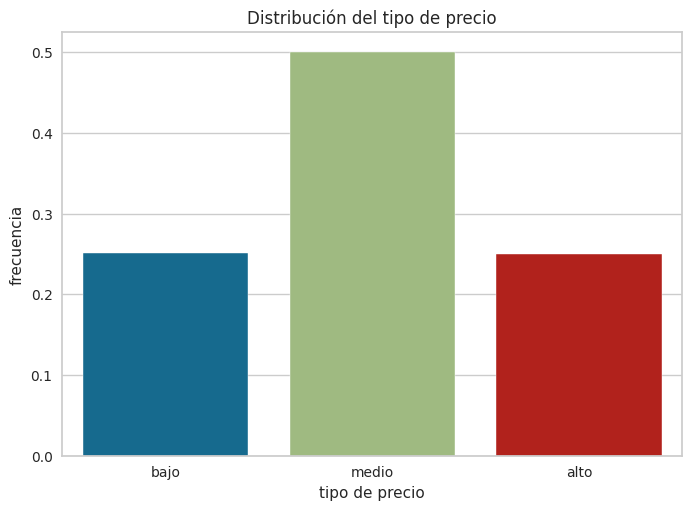

In [78]:
frecuencia_relativa = obtener_frecuencia_relativa(
    dataset_clasificacion["tipo_precio_3"]
)
ax = sns.barplot(x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribución del tipo de precio",
    xlabel="tipo de precio",
    ylabel="frecuencia",
)

Elegimos la tercera alternativa porque nos parece que es una distribución más justa. Si bien se parece a la alternativa 2, al primero separar por tipo de propiedad se puede ver de forma más clara cómo se distribuyen los precios. Las similitudes pueden ser accidentales.

In [79]:
alternativas_a_quitar = ["tipo_precio_2", "tipo_precio_1"]
dataset_clasificacion.drop(alternativas_a_quitar, axis=1, inplace=True)

dataset_clasificacion.rename(columns={"tipo_precio_3": "tipo_precio"}, inplace=True)
dataset_clasificacion_test.rename(columns={"tipo_precio_3": "tipo_precio"}, inplace=True)

## Análisis del Target

Graficamos un mapa de CABA con los avisos coloreados por el tipo de precio

/shared-libs/python3.9/py/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
(62675, 65)


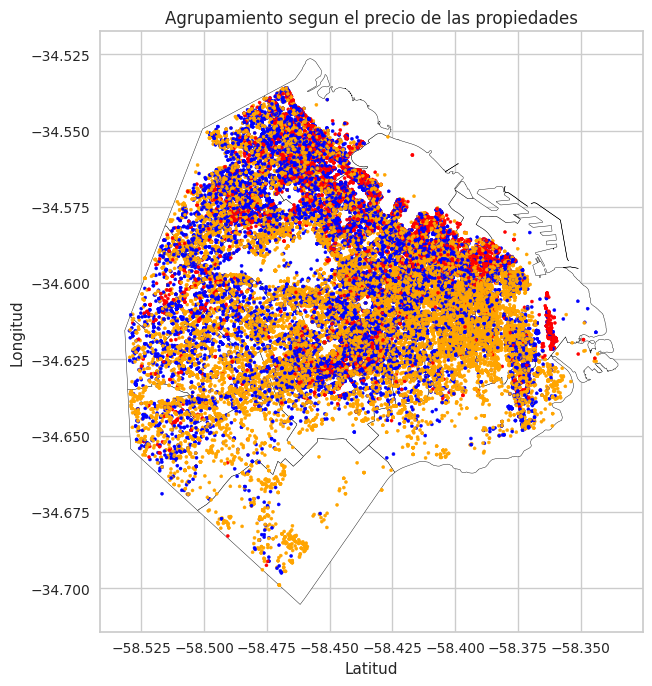

In [80]:
color_map = {0: "blue", 1: "orange", 2: "red"}
graficar_mapa_caba(dataset_clasificacion, color_map, "Agrupamiento segun el precio de las propiedades")

Luego de analizar este gráfico y el realizado para KMeans con 3 clusters notamos que los agrupamientos son muy similares. Esto implica que a pesar de no tener la variable `pxm2` KMeans reconoció que esas propiedades debían ir argupadas por sus otras características.

## Entrenamiento y Predicción

### Modelo 1: Árbol de decisión

Realizamos el modelo para el dataset de clasificación con las columnas originales.

In [81]:
dataset_entrenamiento = dataset_clasificacion.copy()
dataset_entrenamiento_test = dataset_clasificacion_test.copy()

target_train = dataset_clasificacion["tipo_precio"]
target_test = dataset_clasificacion_test["tipo_precio"]

target_reducido_train = dataset_clasificacion["tipo_precio"]
target_reducido_test = dataset_clasificacion_test["tipo_precio"]

clasificacion_train = eliminar_columnas(dataset_entrenamiento, ["pxm2", "property_price", "tipo_precio"])
clasificacion_train = pd.get_dummies(dataset_entrenamiento, columns=["barrio", "property_type"], drop_first=True)

clasificacion_test = eliminar_columnas(dataset_entrenamiento_test, ["pxm2", "property_price", "tipo_precio"])
clasificacion_test = pd.get_dummies(dataset_entrenamiento_test, columns=["barrio", "property_type"], drop_first=True)

Nos aseguramos que los datos de entrenamiento y de test contengan las mismas columnas en el mismo orden.

In [82]:
def insertar_columnas_faltantes(dataset_train, dataset_test):
    for (i, columna) in enumerate(dataset_train.columns):
        if not columna in dataset_test.columns.unique():
            dataset_test.insert(i, columna, 0)

insertar_columnas_faltantes(clasificacion_train, clasificacion_test)

Buscamos los mejores hiperparámetros para el modelo mediante k-fold CrossValidation para obtener la mejor performance. 

Decidimos buscar hiperparámetros que optimizan F1 Score ya que es una métrica que permite balancear *recall* y *precision*. En este caso, *accuracy* no es la mejor métrica porque el dataset no está muy balanceado (al crear el target hay uno de los valores que tiene el doble de datos que los otros dos). 

Realizamos 20 iteraciones para buscar los mejores hiperparámetros, y dividimos el dataset en 5 folds para el Cross Validation. Elegimos usar 5 ya que nos pareció que es una cantidad razonable de subconjuntos. 

In [83]:
n_combinations = 20

params = {'criterion':['gini', 'entropy'],
        'min_samples_leaf':list(range(1,10)), 
        'ccp_alpha':np.linspace(0,0.05,n_combinations),
        'max_depth':list(range(1,6))}

folds = 5

In [84]:
kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier() 

score = make_scorer(sk.metrics.accuracy_score)

randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=score,
                              cv=kfoldcv,
                              n_iter=n_combinations,
                            ) 

randomcv.fit(X=clasificacion_train,y=target_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'ccp_alpha': array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
       0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
       0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
       0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9]},
                   scoring=make_scorer(accuracy_score))

Luego, imprimimos los mejores hiperparámetros que se encontraron y la mejor métrica. Si bien es medio baja, al ser la mejor la utilizaremos para el modelo.

In [85]:
print("Mejores hiperparámetros: ", randomcv.best_params_)
print("Mejor métrica: ", randomcv.best_score_)

Mejores hiperparámetros:  {'min_samples_leaf': 7, 'max_depth': 4, 'criterion': 'entropy', 'ccp_alpha': 0.0}
Mejor métrica:  0.5518149182289589


Entrenamos el modelo y luego predecimos los valores con el dataset de test.

In [86]:
tree_model = randomcv.best_estimator_
model = tree_model.fit(X = clasificacion_train, y = target_train) 

In [87]:
tipo_de_precio_pred = model.predict(clasificacion_test)

Text(70.72222222222221, 0.5, 'True')

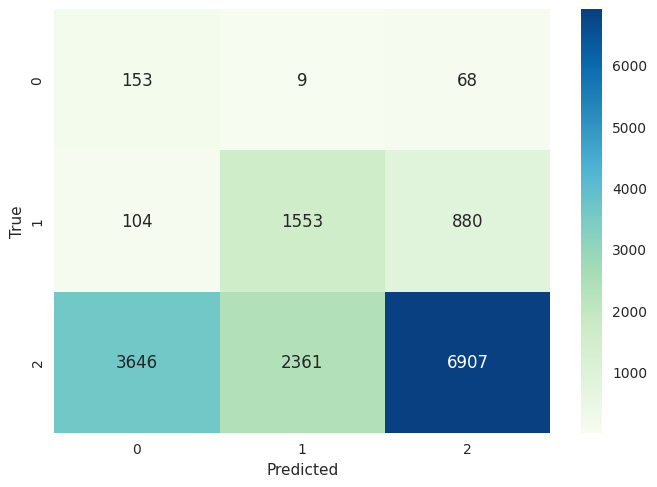

In [88]:
from sklearn.metrics import confusion_matrix
tabla=confusion_matrix(tipo_de_precio_pred, target_test)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Observamos que la clasificación no fue demasiado exitosa (era de esperarse debido a los scores obtenidos de los hiperparámetros) pero las propiedades con tipo de precio `bajo` y `medio` son las que fueron mejor clasificadas.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


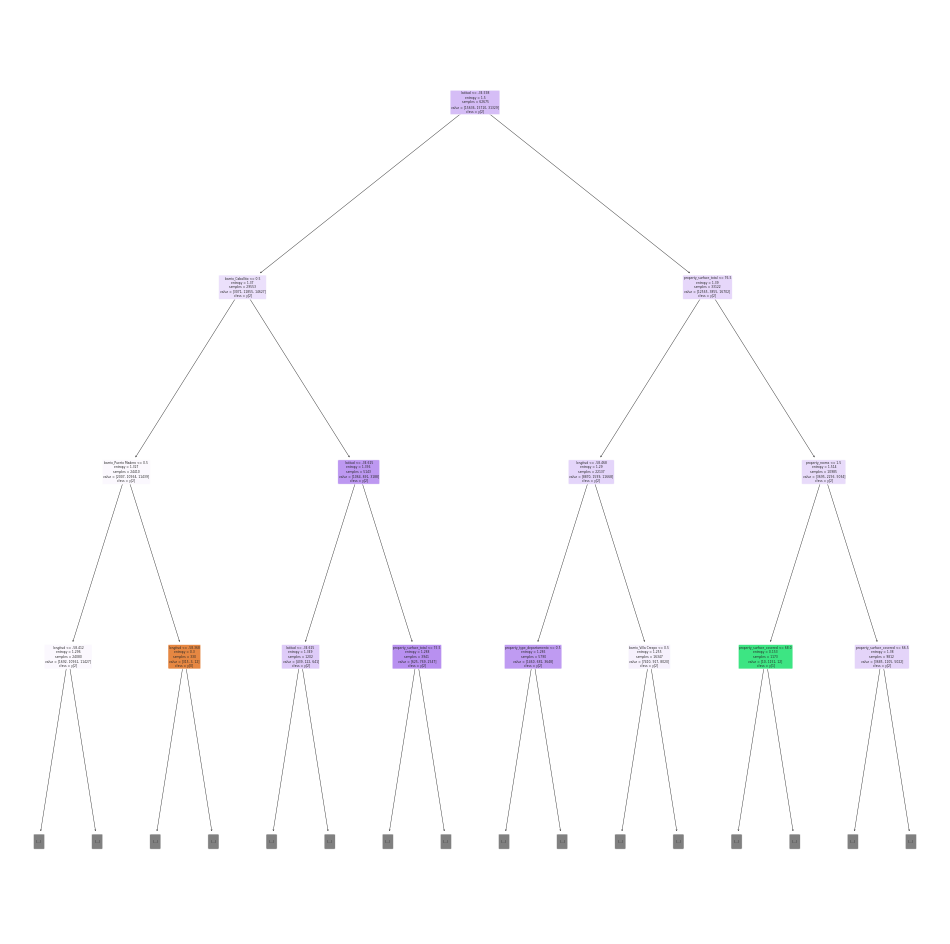

In [89]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model,
                         max_depth=3,
                         feature_names=clasificacion_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

Como podemos observar, el árbol primero pregunta si la latitud de la muestra es menor que -34.599. Si esto se cumple, entonces averigua si el tipo de propiedad es un departamento; si no lo es, entonces clasifica finalmente la muestra como tipo de precio 1 (precio medio). Por otro lado, si es un departamento sigue preguntando si se trata del barrio Caballito; si pertenece a tal barrio será de tipo de precio 2 (precio alto). Y así sucesivamente.

Ahora entrenamos el mismo modelo pero con el dataset reducido. Utilizamos el target generado con el dataset previo y seguimos los mismos pasos.

In [90]:
dataset_entrenamiento_reducido = dataset_concatenado.copy()
dataset_entrenamiento_reducido_test = dataset_concatenado_test.copy()

clasificacion_reducido_train = pd.get_dummies(dataset_entrenamiento_reducido, columns=["barrio", "property_type"], drop_first=True)
clasificacion_reducido_test = pd.get_dummies(dataset_entrenamiento_reducido_test, columns=["barrio", "property_type"], drop_first=True)

insertar_columnas_faltantes(clasificacion_reducido_train, clasificacion_reducido_test)

In [91]:
n_combinations = 20

params = {'criterion':['gini', 'entropy'],
        'min_samples_leaf':list(range(1,10)), 
        'ccp_alpha':np.linspace(0,0.05,n_combinations),
        'max_depth':list(range(1,6))}

folds = 5

In [92]:
kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier() 

score = make_scorer(sk.metrics.accuracy_score)

randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=score,
                              cv=kfoldcv,
                              n_iter=n_combinations,
                            ) 

randomcv.fit(X=clasificacion_reducido_train,y=target_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'ccp_alpha': array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
       0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
       0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
       0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9]},
                   scoring=make_scorer(accuracy_score))

In [93]:
print("Mejores hiperparámetros: ", randomcv.best_params_)
print("Mejor métrica: ", randomcv.best_score_)

Mejores hiperparámetros:  {'min_samples_leaf': 6, 'max_depth': 1, 'criterion': 'gini', 'ccp_alpha': 0.0}
Mejor métrica:  0.4998962903869166


In [94]:
tree_model = randomcv.best_estimator_
model = tree_model.fit(X = clasificacion_reducido_train, y = target_reducido_train) 

In [95]:
tipo_de_precio_pred = model.predict(clasificacion_reducido_test)

Text(70.72222222222221, 0.5, 'True')

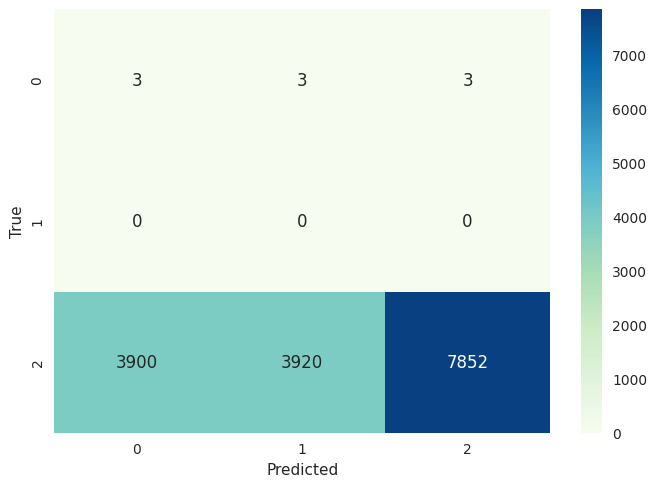

In [96]:
from sklearn.metrics import confusion_matrix
tabla=confusion_matrix(tipo_de_precio_pred, target_reducido_test)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Podemos observar que con el dataset reducido las predicciones dieron peores resultados, lo cual era de esperar dado a que la métrica dio muy baja como para dar buenos resultados. Se puede suponer que si bien los componentes elegidos representaban bien al 97% del dataset original, como ya con ese las métricas no eran las mejores tiene sentido que con el dataset reducido hayan dado peor.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


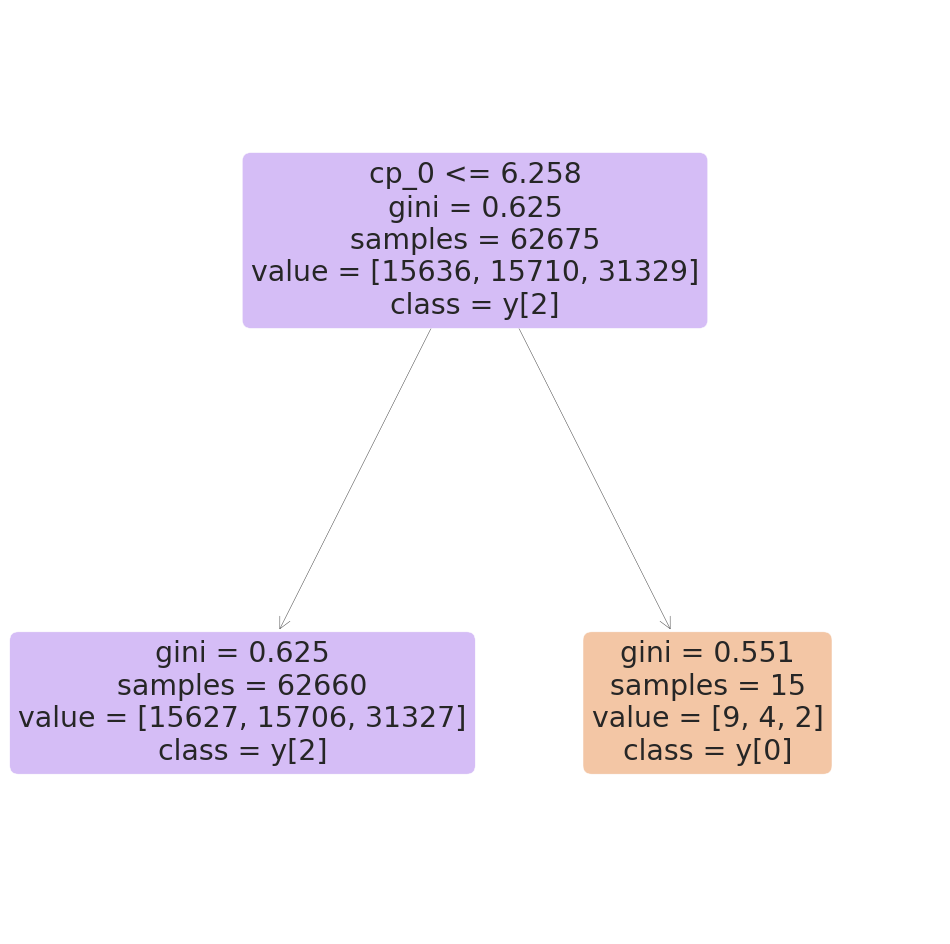

In [97]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model,
                         max_depth=3,
                         feature_names=clasificacion_reducido_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc9b46f5-899c-4314-8e44-8f9e77759939' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>